<a href="https://colab.research.google.com/github/vedthebest/Pneumonia-Detection/blob/main/Capstone_CV1_G1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The project code is available as different files 
https://github.com/vedthebest/Pneumonia-Detection

Multiple models have been considered and hence each are in a separate colab file which are merged in here. The models considered are,
1) Densenet
2) Densenet with chexnet weights.
3) CNN
4) FCNN
5) Mobilenetv2
6) Mobilenetv2 with transfer learning.
7) option in 6 with additional localization layer.
8) image augmentation with option 6.
9) unet with mobilenet

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

**Capstone Project - RSNA Pneumonia Detection Challenge
Problem Statement**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of inflammation in an image. Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image. While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related. In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

## Import Packages

In [ ]:
import pandas as pd
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from glob import glob
from skimage.transform import resize
from skimage import io, measure
import cv2, random

Mount the data drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Exploratory Data Analysis (EDA)**

## Here as a part of EDA, we will:

*   Start with understanding of the data with a brief on train/test labels and respective class info
*   Look at the first five rows of both the csvs (train and test)
*   Identify how are classes and target distributed
*   Check the number of patients with 1, 2, ... bounding boxes
*   Read and extract metadata from dicom files
*   Perform analysis on some of the features from dicom files
*   Check some random images from the training dataset
*   Draw insights from the data at various stages of EDA

## Reading CSVs

Images for the current stage in the stage_2_train_images and stage_2_test_images.

Training data: stage_2_train_labels.csv
stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

In [ ]:
#load train labels in df
train_labels_df = pd.read_csv("/content/drive/MyDrive/capstone/stage_2_train_labels.csv")

In [ ]:
train_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


The bounding box information is present for only 9555 records out of 30227.

In [ ]:
train_labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


### Read the deatiled class info data

In [ ]:
detail_df = pd.read_csv("/content/drive/MyDrive/capstone/stage_2_detailed_class_info.csv")

In [ ]:
detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
detail_df.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity


In [ ]:
detail_df['class'].unique()

array(['No Lung Opacity / Not Normal', 'Normal', 'Lung Opacity'],
      dtype=object)

There are 3 classes 

 > 1) Normal

 > 2) Lung Opacity

 > 3) No lung opacity /not normal (which is not related to pneumonia.)







In [ ]:
print(f'Train Labels dataframe has {train_labels_df.shape[0]} rows and {train_labels_df.shape[1]} columns')
print(f'Class info dataframe has {detail_df.shape[0]} rows and {detail_df.shape[1]} columns')
print('Number of duplicates in patientID in train labels dataframe: {}'.format(len(train_labels_df) - (train_labels_df['patientId'].nunique())))
print('Number of duplicates in patientID in class info dataframe: {}'.format(len(detail_df) - (detail_df['patientId'].nunique())))

Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns
Number of duplicates in patientID in train labels dataframe: 3543
Number of duplicates in patientID in class info dataframe: 3543


In [ ]:
print('Numbers of nulls in bounding boxes columns are equal to the 0s we\'ve in Target column'); print('--'*40)
print('Checking nulls in bounding boxes columns: {}'.format(train_labels_df[['x', 'y', 'width', 'height']].isnull().sum().to_dict())) 
print('Checking value counts for the targets: {}'.format(train_labels_df['Target'].value_counts().to_dict()))

Numbers of nulls in bounding boxes columns are equal to the 0s we've in Target column
--------------------------------------------------------------------------------
Checking nulls in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Checking value counts for the targets: {0: 20672, 1: 9555}


Lets check the distribution of `Target` and `class` column
--------------------------------------------------------------------------------


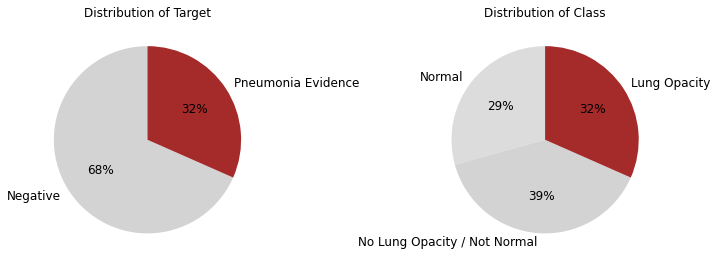

In [ ]:
print('Lets check the distribution of `Target` and `class` column'); print('--'*40)
fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(121)
g = (train_labels_df['Target'].value_counts()
    .plot(kind = 'pie', autopct = '%.0f%%', 
          labels = ['Negative', 'Pneumonia Evidence'], 
          colors = ['lightgray', 'brown'], 
          startangle = 90, 
          title = 'Distribution of Target', fontsize = 12)
    .set_ylabel(''))
ax = fig.add_subplot(122)
g = (detail_df['class'].value_counts().sort_index(ascending = False)
    .plot(kind = 'pie', autopct = '%.0f%%', 
          colors = ['gainsboro', 'lightgray', 'brown'], 
          startangle = 90, title = 'Distribution of Class', 
          fontsize = 12)
    .set_ylabel(''))
plt.tight_layout()

In [ ]:
print('Let\'s group by patient IDs and check number of bounding boxes for each unique patient ID');print('--'*40)
bboxes = train_labels_df.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels_df.merge(bboxes, on = 'patientId', how = 'left')
print('Number of unique patient IDs in the dataset: {}'.format(len(bboxes)))
print('\nNumber of patientIDs per bboxes in the dataset')
(bboxes.groupby('number_of_boxes')
.size()
.to_frame('number_of_patientIDs_per_boxes')
.reset_index()
.set_index('number_of_boxes')
.sort_values(by = 'number_of_boxes'))

Let's group by patient IDs and check number of bounding boxes for each unique patient ID
--------------------------------------------------------------------------------
Number of unique patient IDs in the dataset: 26684

Number of patientIDs per bboxes in the dataset


,number_of_patientIDs_per_boxes
number_of_boxes,
1,23286
2,3266
3,119
4,13


In [ ]:
print('Let\'s also check whether each patientId has only one type of class'); print('--'*40)
print('Yes, each patientId is associated with only {} class'.format(detail_df.groupby(['patientId'])['class'].nunique().max()))

# Merge the two dataframes
train_class = pd.concat([train_labels_df, detail_df['class']], axis = 1)
print('Shape of the dataset after the merge: {}'.format(train_class.shape))

Let's also check whether each patientId has only one type of class
--------------------------------------------------------------------------------
Yes, each patientId is associated with only 1 class
Shape of the dataset after the merge: (30227, 7)


Observations from the CSVs

Based on analysis above, some of the observations:

    Training data is having a set of patientIds and bounding boxes. Bounding boxes are defined as follows: x, y, width and height.
    There are multiple records for patients. Number of duplicates in patientID = 3,543.
    There is also a binary target column i.e. Target indicating there was evidence of pneumonia or no definitive evidence of pneumonia.
    Class label contains: No Lung Opacity/Not Normal, Normal and Lung Opacity.
    Chest examinations with Target = 1 i.e. ones with evidence of Pneumonia are associated with Lung Opacity class.
    Chest examinations with Target = 0 i.e. those with no definitive effidence of Pneumonia are either of Normal or No Lung Opacity / Not Normal class.
    About 23,286 patientIds (~87% of them) provided have 1 bounding boxes while 13 patients have 4 bounding boxes!!!!


Let's merge the labels and details dataframe

In [ ]:
#merge the two df's and drop target
merged_df=pd.concat([train_labels_df,detail_df['class']],axis = 1 )

In [ ]:
merged_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 1.6+ MB


In [ ]:
merged_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Lung Opacity                     9555
Normal                           8851
Name: class, dtype: int64

The classes seem to be fairly distributed. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plot

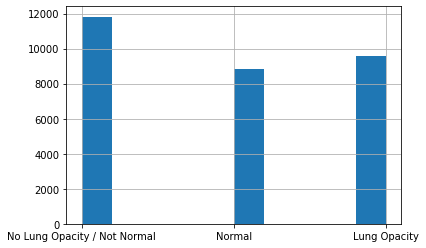

In [ ]:
merged_df['class'].hist()

In [ ]:
pd.isnull(merged_df).sum()

patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
dtype: int64

There are many NAN's for x, y, width and height. lets find the class corresponding to these NAN's



In [ ]:
new_df=merged_df[merged_df.isna().any(axis=1)]

In [ ]:
new_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal


In [ ]:
new_df['class'].value_counts()

No Lung Opacity / Not Normal    11821
Normal                           8851
Name: class, dtype: int64

As seen above the class of data containing Null's is either "Normal" or "No Lung Opacity/Not Normal" and both do not belong to pneumonia class.
However we will use the data for training so that more variety can be fed to the model.

In [ ]:
new_df['Target'].value_counts()

0    20672
Name: Target, dtype: int64

This shows that both no lung opacity/not normal and normal have target as "0" indicating there is no pneumonia.

In [ ]:
merged_df['y_max'] = merged_df['y'] + merged_df['height']

In [ ]:
merged_df['x_max'] = merged_df['x'] + merged_df['width']

In [ ]:
merged_df.head()

,patientId,x,y,width,height,Target,class,y_max,x_max
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0


In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [ ]:
import pydicom as dcm

In [ ]:
merged_df['patientId'].nunique()

26684

There are 26684 unique patient ID's in training data set.

The below listing shows the patient ids and number of bounding boxes.

In [ ]:
bar_df=merged_df.groupby('patientId').size().value_counts().reset_index()

In [ ]:
bar_df.rename(columns = {'index':'No of BB'}, inplace = True)

In [ ]:
bar_df.rename(columns = {bar_df.columns[1]:'No of patients'}, inplace = True)

In [ ]:
bar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   No of BB        4 non-null      int64
 1   No of patients  4 non-null      int64
dtypes: int64(2)
memory usage: 192.0 bytes


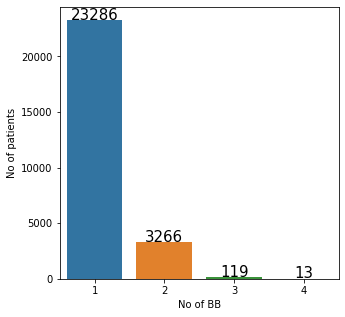

In [ ]:
plot.figure(figsize=(5, 5))
plots = sns.barplot(x="No of BB", y="No of patients", data=bar_df)
# Iterrating over the bars one-by-one
for bar in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    plots.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 5),
                   textcoords='offset points')

start processing of dcm images.

In [ ]:
base_path='/content/drive/MyDrive/capstone/stage_2_train_images'

In [ ]:
import os
len(os.listdir(base_path))

KeyboardInterrupt: ignored

There are 26684 files present in training folder which matches with unique patient records in df.

In [ ]:
#read and print dcm metadata
image_path = base_path+'/'+merged_df['patientId'].iloc[0]+'.dcm'
ds = dcm.dcmread(image_path)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [ ]:
image_path = base_path+'/'+merged_df['patientId'].iloc[5]+'.dcm'
ds = dcm.dcmread(image_path)
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.6379.1517874325.469569
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

dcm file has lot of metadata which can be added to merged df and used for further EDA.

In [ ]:
ds.PixelSpacing[0]

'0.139'

**Observations from dicom image files**

From the above sample we can see that dicom file contains some of the information that can be used for further analysis such as sex, age, body part examined (which should be mostly chest), view position and modality. Size of this image is 1024 x 1024 (rows x columns).

## Feature extraction from the dicom image files

Above we identified some features from the dicom files that can explored/used, let's focus on the following analysis from the image files

To understand distribution of age for those with evidence of lung opacity and those with no definite evidence of lung opacity.
To understand distribution of male and female for those with evidence of lung opacity and those with no definite evidence of lung opacity
Explore different view positions in the dataset
Explore modallity

To get the features from dicom image files, we will make use of function (get_tags) defined in (eda).

In [ ]:
print('Read the training images file names and path'); print('--'*40)
images = pd.DataFrame({'path': glob(os.path.join(base_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])
print('Number of images in the training folder: {}'.format(images.shape[0]))
print('Columns in the training images dataframe: {}'.format(list(images.columns)))
assert images.shape[0] == len(list(set(train_class['patientId']))), 'Number of training images should be equal to the unique patientIds we have'

Read the training images file names and path
--------------------------------------------------------------------------------
Number of images in the training folder: 26684
Columns in the training images dataframe: ['path', 'patientId']


In [ ]:
print('Merge path from the `images` dataframe with `merged_df` dataframe'); print('--'*40)
merged_df = merged_df.merge(images, on = 'patientId', how = 'left')
print('Shape of the `train_class` dataframe after merge: {}'.format(merged_df.shape))
del images

Merge path from the `images` dataframe with `merged_df` dataframe
--------------------------------------------------------------------------------


NameError: ignored

In [ ]:
# Helper function to get additional features from dicom images
def get_tags(data, path):
    images = os.listdir(path)
    for _, name in tqdm_notebook(enumerate(images)):
        img_path = os.path.join(path, name)
        img_data = dcm.read_file(img_path)
        idx = (data['patientId'] == img_data.PatientID)
        data.loc[idx,'PatientSex'] = img_data.PatientSex
        data.loc[idx,'PatientAge'] = pd.to_numeric(img_data.PatientAge)
        data.loc[idx,'BodyPartExamined'] = img_data.BodyPartExamined
        data.loc[idx,'ViewPosition'] = img_data.ViewPosition
        data.loc[idx,'Modality'] = img_data.Modality


In [ ]:
print('Get features such as {} from training images'.format(('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality')))
get_tags(merged_df, base_path)

print('Saving the feature engineered dataframe for future use'); print('--'*40)
#merged_df.to_pickle('./output/train_feature_engineered.pkl')
# Saving the training_data for further use:
merged_df.to_pickle('/content/drive/MyDrive/capstone/train_feature_engineered.pkl')

Get features such as ('PatientSex', 'PatientAge', 'BodyPartExamined', 'ViewPosition', 'Modality') from training images
Saving the feature engineered dataframe for future use
--------------------------------------------------------------------------------


In [ ]:
merged_df.head()


,patientId,x,y,width,height,Target,class,y_max,x_max,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,51.0,CHEST,PA,CR
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,48.0,CHEST,PA,CR
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,19.0,CHEST,AP,CR
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,28.0,CHEST,PA,CR
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,/content/drive/MyDrive/capstone/stage_2_train_...,F,32.0,CHEST,AP,CR


In [ ]:
#loop through all the training images and extract their key metadata and make new columns in merged_df.
"""
for idx,pid in enumerate(merged_df['patientId']):
  #print(pid)
  path=base_path+'/'+pid+'.dcm'
  print(path)
  ds = dcm.dcmread(path)
  print(ds)
  #insert metadata into merged_df
  merged_df.loc[idx,'Modality']=ds.Modality
  merged_df.loc[idx,'ConversionType']=ds.ConversionType
  merged_df.loc[idx,'PatientSex']=ds.PatientSex
  merged_df.loc[idx,'PatientAge']=ds.PatientAge
  merged_df.loc[idx,'Body Part Examined']=ds.BodyPartExamined
  merged_df.loc[idx,'ViewPosition']=ds.ViewPosition
  merged_df.loc[idx,'Rows']=ds.Rows
  merged_df.loc[idx,'Columns']=ds.Columns
  merged_df.loc[idx,'PixelSpacing']=ds.PixelSpacing[0]
  """

"\nfor idx,pid in enumerate(merged_df['patientId']):\n  #print(pid)\n  path=base_path+'/'+pid+'.dcm'\n  print(path)\n  ds = dcm.dcmread(path)\n  print(ds)\n  #insert metadata into merged_df\n  merged_df.loc[idx,'Modality']=ds.Modality\n  merged_df.loc[idx,'ConversionType']=ds.ConversionType\n  merged_df.loc[idx,'PatientSex']=ds.PatientSex\n  merged_df.loc[idx,'PatientAge']=ds.PatientAge\n  merged_df.loc[idx,'Body Part Examined']=ds.BodyPartExamined\n  merged_df.loc[idx,'ViewPosition']=ds.ViewPosition\n  merged_df.loc[idx,'Rows']=ds.Rows\n  merged_df.loc[idx,'Columns']=ds.Columns\n  merged_df.loc[idx,'PixelSpacing']=ds.PixelSpacing[0]\n  "

In [ ]:
merged_df.head()

,patientId,x,y,width,height,Target,class,y_max,x_max,Modality,ConversionType,PatientSex,PatientAge,Body Part Examined,ViewPosition,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,CR,WSD,F,51,CHEST,PA,1024.0,1024.0,0.143000
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,CR,WSD,F,48,CHEST,PA,1024.0,1024.0,0.194311
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,CR,WSD,M,19,CHEST,AP,1024.0,1024.0,0.168000
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN,CR,WSD,M,28,CHEST,PA,1024.0,1024.0,0.143000
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,CR,WSD,F,32,CHEST,AP,1024.0,1024.0,0.139000


In [ ]:
#convert patient age to number
merged_df['PatientAge']=pd.to_numeric(merged_df['PatientAge'])

In [ ]:
# Saving the training_data for further use:
merged_df.to_pickle('merged_df.pkl')

perform EDA on the merged data.

In [ ]:
merged_df = pd.read_pickle('merged_df.pkl')

In [ ]:
merged_df['Body Part Examined'].value_counts()

CHEST    30227
Name: Body Part Examined, dtype: int64

All the data is collected from chest region.

In [ ]:
merged_df['ConversionType'].value_counts()

WSD    30227
Name: ConversionType, dtype: int64

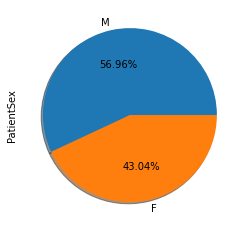

In [ ]:
merged_df['PatientSex'].value_counts().plot(kind='pie',autopct='%1.2f%%',shadow='True')

There are 56.96% male patients and roughly 43% female patients.

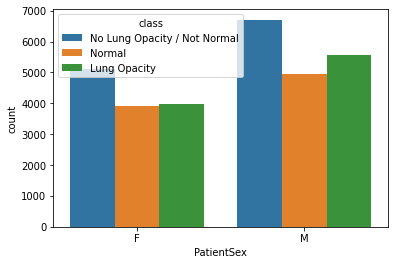

In [ ]:
sns.countplot(x = merged_df['PatientSex'], data = merged_df,  hue = 'class')

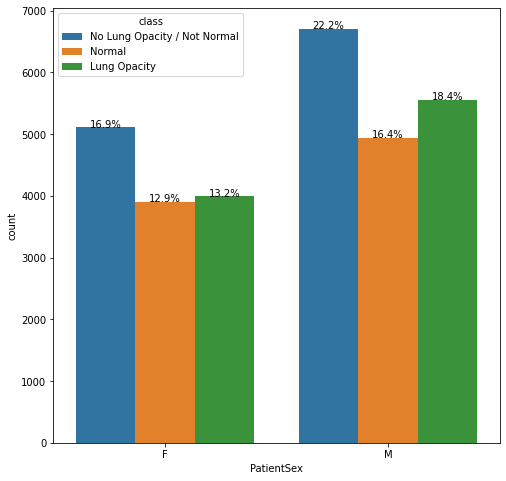

In [ ]:
plot.figure(figsize=(8, 8))
plots = sns.countplot(x="PatientSex", hue="class", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()
    

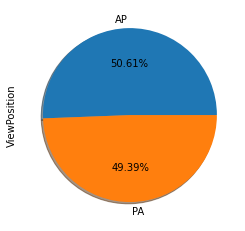

In [ ]:
merged_df['ViewPosition'].value_counts().plot(kind='pie',autopct='%1.2f%%',shadow='True')

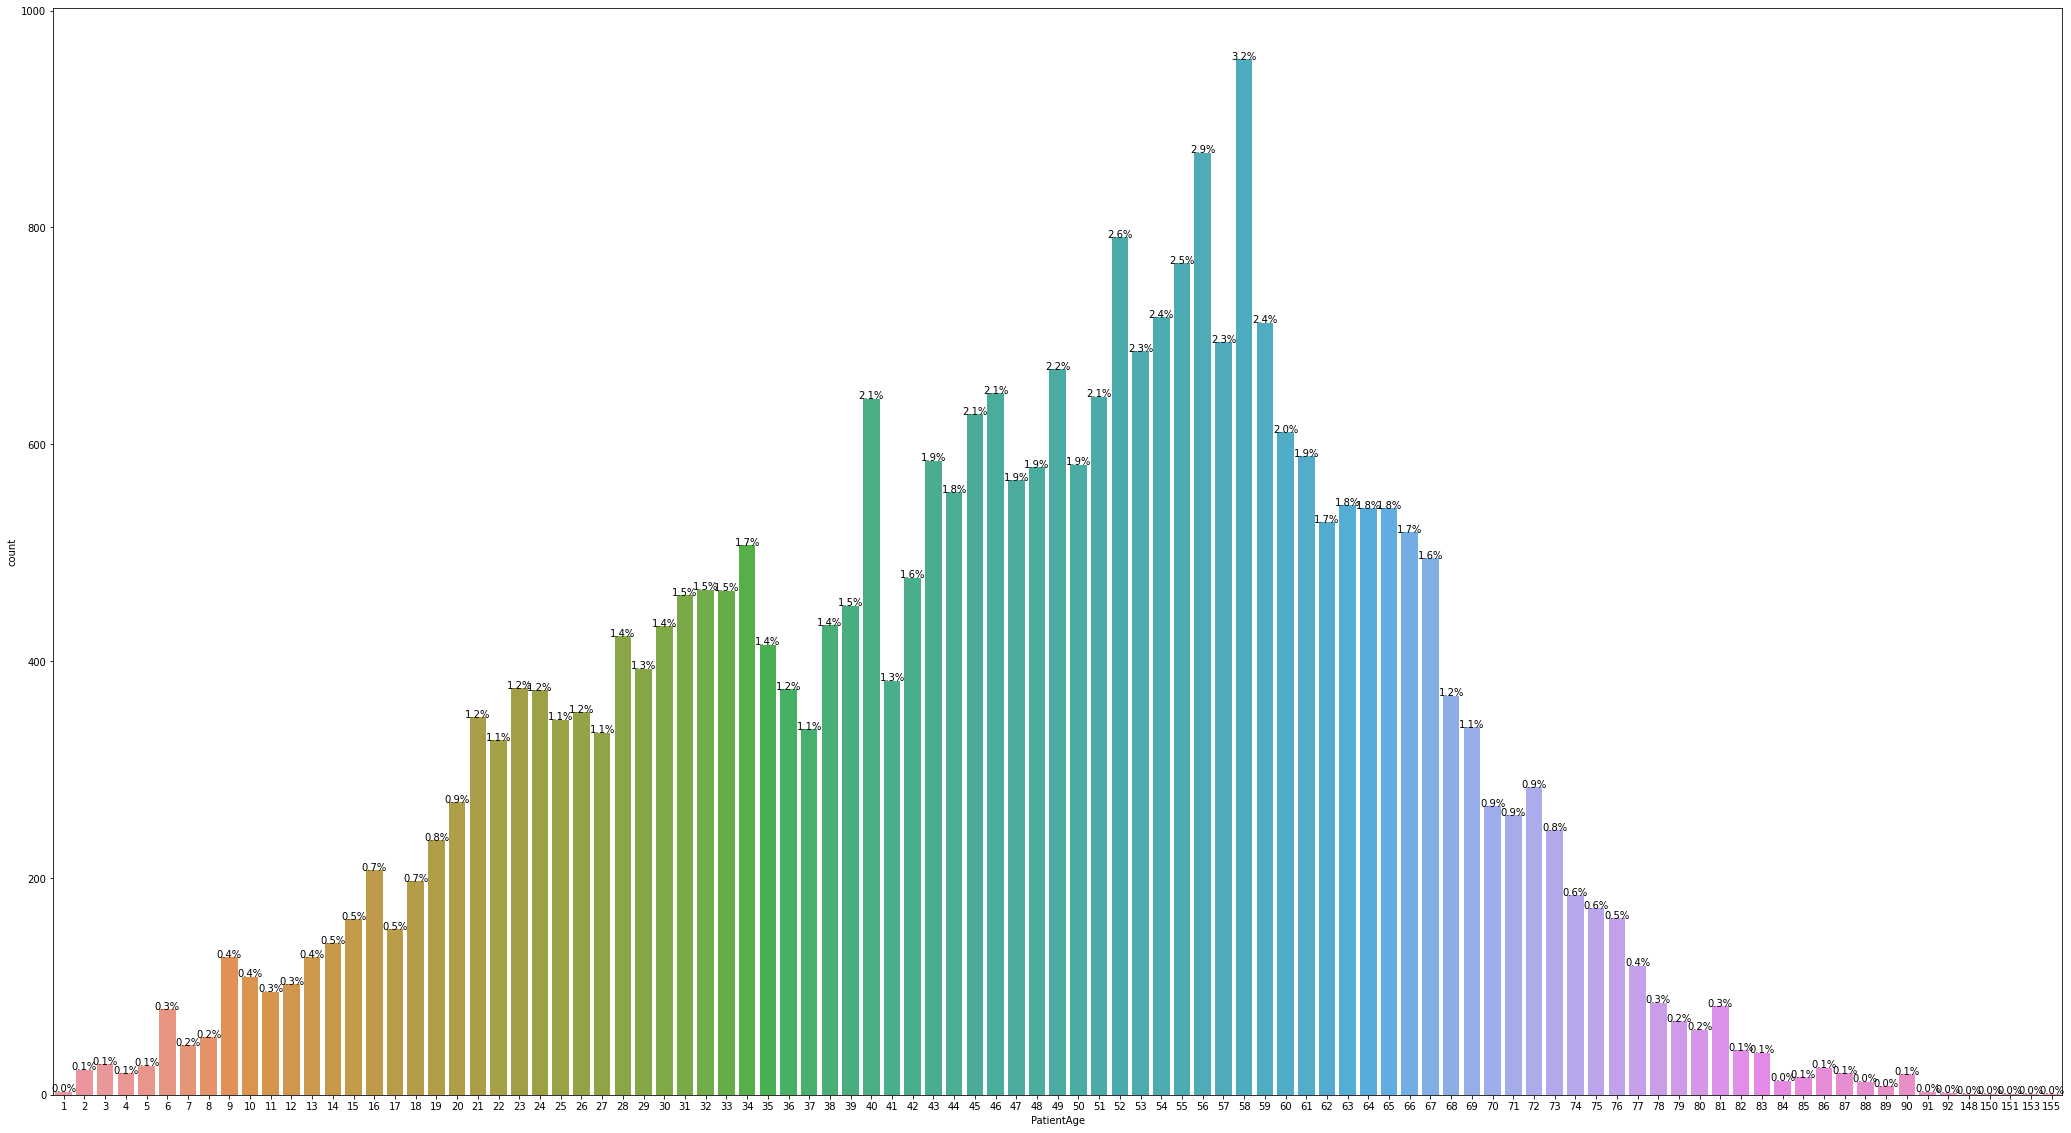

In [ ]:
#merged_df['PatientAge'].value_counts().plot(kind='countplot',figsize=(24,8))
plot.figure(figsize=(36,20))
plots=sns.countplot(x='PatientAge',data=merged_df.sort_values('PatientAge'))
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

The age numbers exist beyond 100 indicating the data may have been recorded incorrectly.

In [ ]:
merged_df[merged_df['PatientAge']>=100]['patientId']

3921     3b8b8777-a1f6-4384-872a-28b95f59bf0d
11032    73aeea88-fc48-4030-8564-0a9d7fdecac4
17213    a4e8e96d-93a6-4251-b617-91382e610fab
26488    ec3697bd-184e-44ba-9688-ff8d5fbf9bbc
27746    f632328d-5819-4b29-b54f-adf4934bbee6
Name: patientId, dtype: object

There are 5 records with age beyond 100.

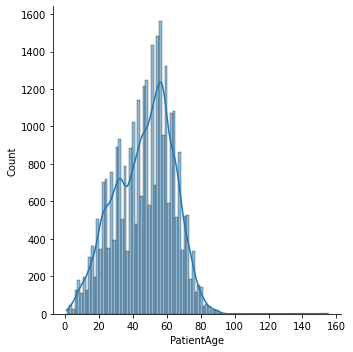

In [ ]:
sns.displot(merged_df['PatientAge'],kde='true')

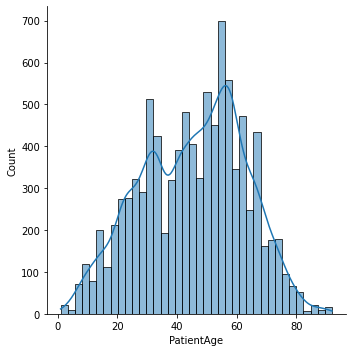

In [ ]:
tmp_df=merged_df[merged_df['Target']==1]
#tmp_df.head()
sns.displot(tmp_df['PatientAge'],kde='true')

lets group the ages and explore target and class distribution.

In [ ]:
patient_age_arr = np.linspace(0, 160, 17)

In [ ]:
merged_df['PatientAgeGroup'] = pd.cut(merged_df['PatientAge'], patient_age_arr)
merged_df['PatientAgeGroup'].value_counts()

(50.0, 60.0]      7446
(40.0, 50.0]      5671
(60.0, 70.0]      4730
(30.0, 40.0]      4551
(20.0, 30.0]      3704
(10.0, 20.0]      1688
(70.0, 80.0]      1637
(0.0, 10.0]        515
(80.0, 90.0]       275
(90.0, 100.0]        5
(150.0, 160.0]       3
(140.0, 150.0]       2
(100.0, 110.0]       0
(110.0, 120.0]       0
(120.0, 130.0]       0
(130.0, 140.0]       0
Name: PatientAgeGroup, dtype: int64

Most patients are in age brackets [50-60],[40-50]. Those is ages below 10 and above 80 are not impacted.

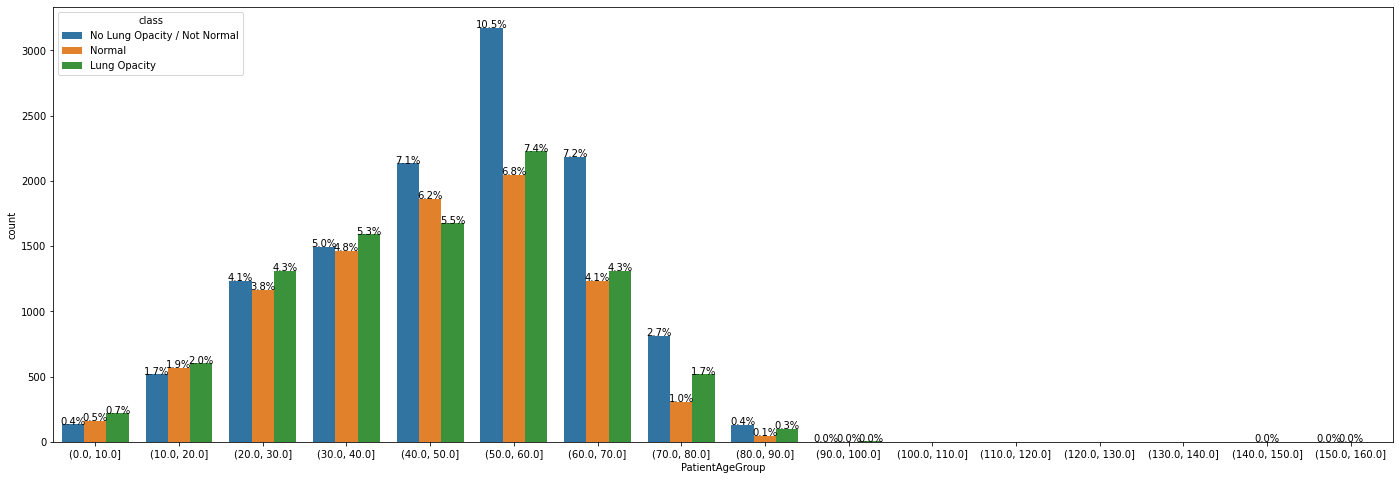

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="class", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

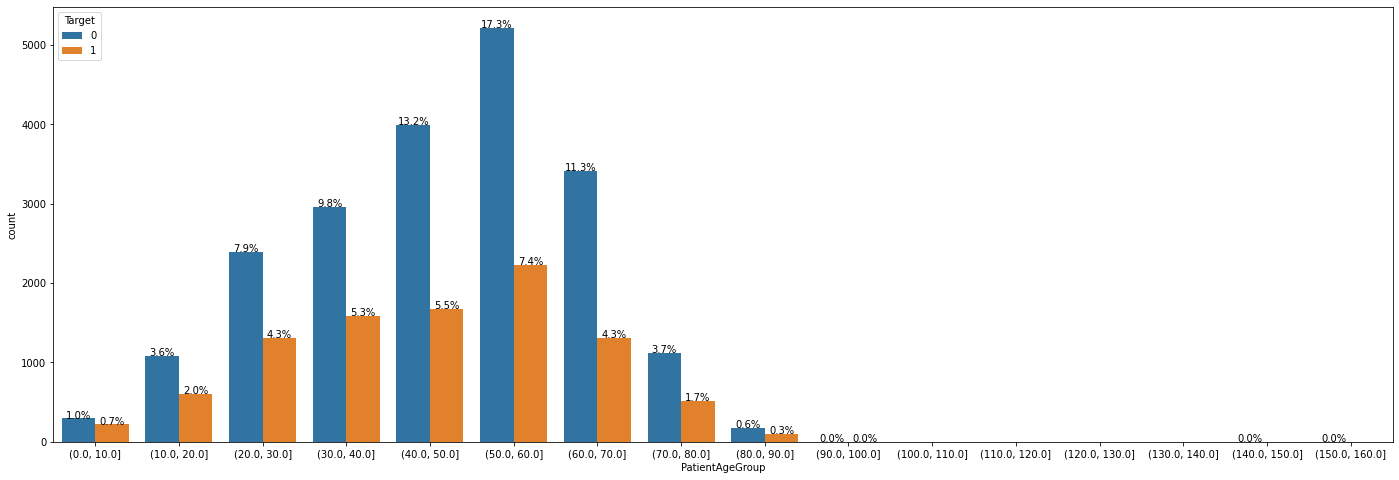

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="Target", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

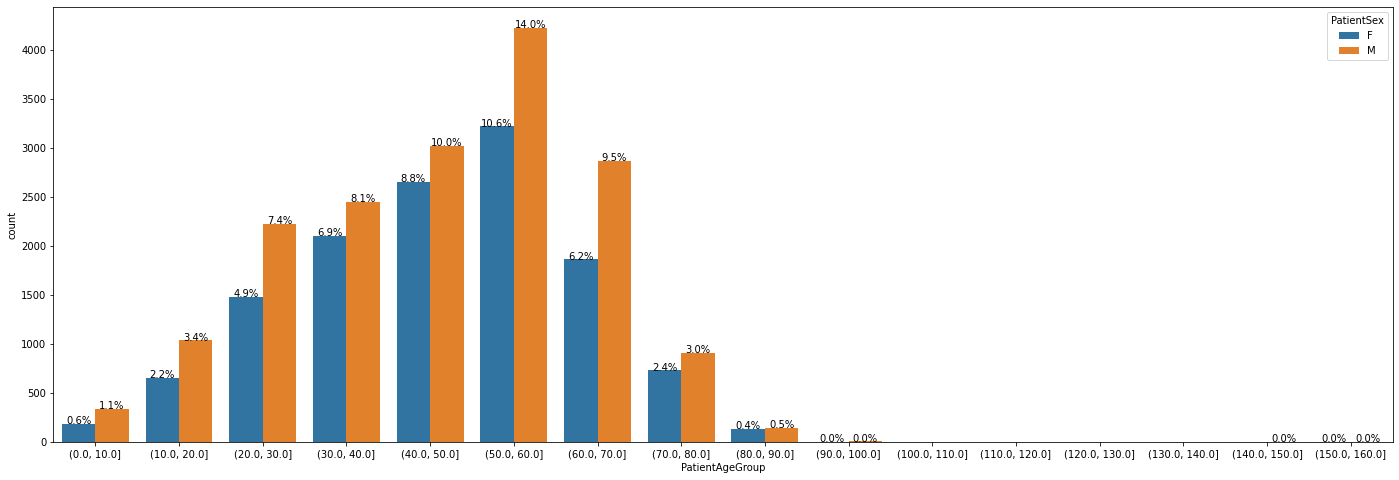

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="PatientSex", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

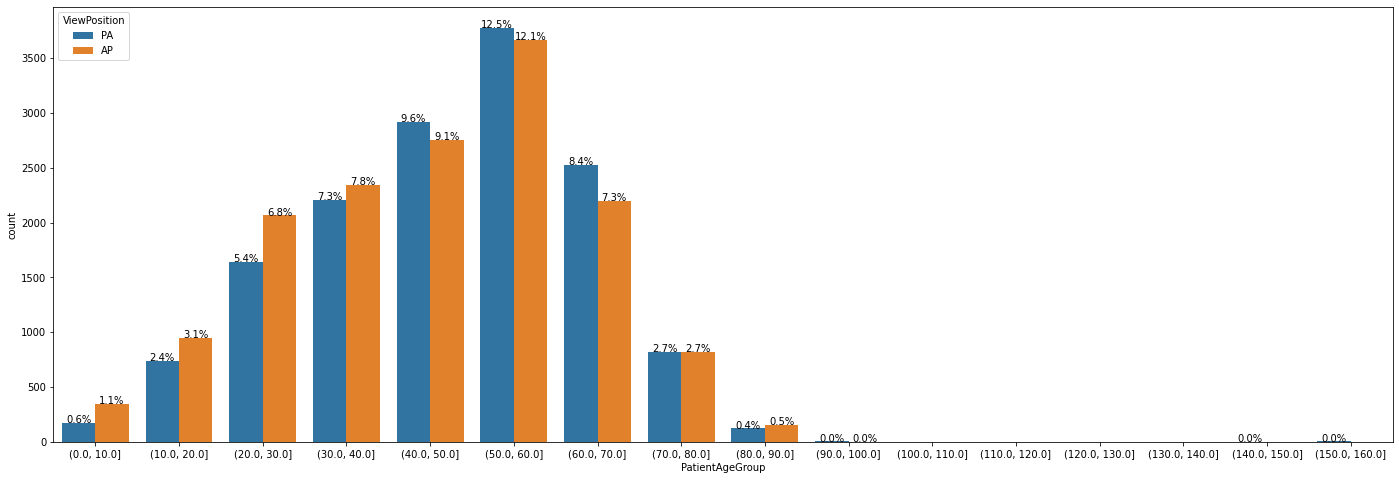

In [ ]:
plot.figure(figsize=(24, 8))
plots = sns.countplot(x="PatientAgeGroup", hue="ViewPosition", data=merged_df)
total=30227
# Iterrating over the bars one-by-one
for p in plots.patches:
 
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    plots.annotate(percentage, (x, y),ha='center')
plot.show()

In [ ]:
# Saving the training_data for further use:
merged_df.to_pickle('/content/drive/MyDrive/Colab/capstoneCV1/pklfiles/merged_df.pkl')

Lets explore bounding boxes.

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.0 MB/s 


In [ ]:

import pydicom as dcm
from google.colab.patches import cv2_imshow

In [ ]:
#load the saved pickle file.
load_df= pd.read_pickle('/content/drive/MyDrive/capstone//merged_df.pkl')

In [ ]:
load_df['x']=load_df['x'].fillna(0)
load_df['y']=load_df['y'].fillna(0)
load_df['y_max']=load_df['y_max'].fillna(0)
load_df['x_max']=load_df['x_max'].fillna(0)

In [ ]:
t_df=load_df[load_df['Target']==1]

In [ ]:
base_path='/content/drive/MyDrive/capstone/stage_2_train_images'
def show_image_bb(df,index):
  image_path = base_path+'/'+df.iloc[index]['patientId']+'.dcm'
  ds = dcm.dcmread(image_path)
  img=ds.pixel_array # store pixel data
     
  # Blue color in BGR
  color = (255, 0, 0)
  thickness = 4
  start_point=(int(df.iloc[index]['x']),int(df.iloc[index]['y']))
  end_point = (int(df.iloc[index]['x_max']),int(df.iloc[index]['y_max']))
  img = cv2.rectangle(img, start_point, end_point, color, thickness)
  img=cv2.resize(img, (256, 256))
  # add patient profile
  print("Age:",df.iloc[index]['PatientAge'],"ID:",df.iloc[index]['patientId'])
  print("Sex:",df.iloc[index]['PatientSex'],"View:",df.iloc[index]['ViewPosition'],"Class:",df.iloc[index]['class'])
  cv2_imshow(img)


Age: 32 ID: 00436515-870c-4b36-a041-de91049b9ab4
Sex: F View: AP Class: Lung Opacity


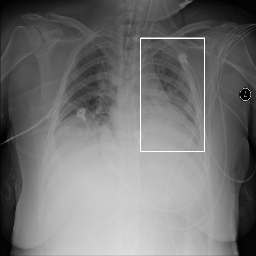

In [ ]:
show_image_bb(t_df,1)

Age: 34 ID: 02099738-7465-4786-b71c-de8cdac477c3
Sex: F View: AP Class: Lung Opacity


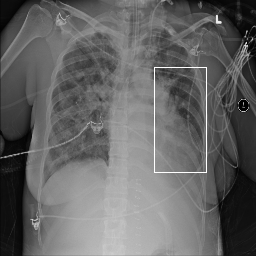

In [ ]:
show_image_bb(t_df,45)

Age: 66 ID: 31102758-a5ba-44c9-b480-b744bcfcb861
Sex: F View: AP Class: Lung Opacity


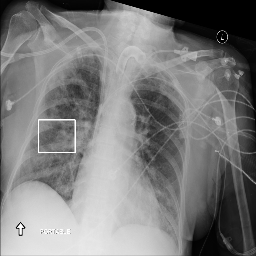

In [ ]:
show_image_bb(t_df,1000)

lets display images with multiple bounding boxes

In [ ]:
dup_df=t_df[t_df.duplicated('patientId',keep=False)]

In [ ]:
dup_df.head()

,patientId,x,y,width,height,Target,class,y_max,x_max,Modality,ConversionType,PatientSex,PatientAge,Body Part Examined,ViewPosition,Rows,Columns,PixelSpacing,PatientAgeGroup
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,CR,WSD,F,32,CHEST,AP,1024.0,1024.0,0.139,"(30.0, 40.0]"
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,605.0,818.0,CR,WSD,F,32,CHEST,AP,1024.0,1024.0,0.139,"(30.0, 40.0]"
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,681.0,483.0,CR,WSD,M,75,CHEST,PA,1024.0,1024.0,0.143,"(70.0, 80.0]"
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,712.0,857.0,CR,WSD,M,75,CHEST,PA,1024.0,1024.0,0.143,"(70.0, 80.0]"
14,00aecb01-a116-45a2-956c-08d2fa55433f,288.0,322.0,94.0,135.0,1,Lung Opacity,457.0,382.0,CR,WSD,F,6,CHEST,AP,1024.0,1024.0,0.168,"(0.0, 10.0]"


In [ ]:
dup_df.shape

(6941, 19)

There are 6941 duplicate records.

In [ ]:
dup_pid_arr=dup_df['patientId'].unique()

In [ ]:
len(dup_pid_arr)

3398

In [ ]:
#choose any two patient Id's
print(dup_pid_arr[0])
print(dup_pid_arr[5])

00436515-870c-4b36-a041-de91049b9ab4
010ccb9f-6d46-4380-af11-84f87397a1b8


In [ ]:
def show_duplicates_bb(df,index,ptid):

  #find number of BB's and their {x,y,x_max,y_max}
  if(index>=0):
    #find patient ID of index
    pid= df.iloc[index]['patientId']
  else:
    pid=ptid

  #find count of records
  pid_count=df[df['patientId']==pid].value_counts().sum()
  print(pid,pid_count)
  tdf=df[df['patientId']==pid]
  image_path = base_path+'/'+pid+'.dcm'
  ds = dcm.dcmread(image_path)
  img=ds.pixel_array # store pixel data
  for idx in range(pid_count):
    x=tdf.iloc[idx]['x']
    y=tdf.iloc[idx]['y']
    x_max=tdf.iloc[idx]['x_max']
    y_max=tdf.iloc[idx]['y_max']
    print(pid,x,y,x_max,y_max)
     
    # Blue color in BGR
    color = (255, 0,0)

    if(idx > 0):
      color = (0, 255,128+(idx*25))
    
    thickness = 4
    start_point=(int(x),int(y))
    end_point = (int(x_max),int(y_max))
    img = cv2.rectangle(img, start_point, end_point, color, thickness)
  
    
  img=cv2.resize(img, (256, 256))
  # add patient profile
  print("Age:",df.iloc[index]['PatientAge'],"ID:",df.iloc[index]['patientId'])
  print("Sex:",df.iloc[index]['PatientSex'],"View:",df.iloc[index]['ViewPosition'],"Class:",df.iloc[index]['class'])
  cv2_imshow(img)

00436515-870c-4b36-a041-de91049b9ab4 2
00436515-870c-4b36-a041-de91049b9ab4 264.0 152.0 477.0 531.0
00436515-870c-4b36-a041-de91049b9ab4 562.0 152.0 818.0 605.0
Age: 32 ID: 00436515-870c-4b36-a041-de91049b9ab4
Sex: F View: AP Class: Lung Opacity


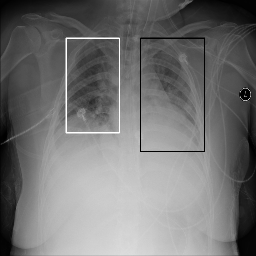

In [ ]:
show_duplicates_bb(dup_df,0,0)

In [ ]:
pid_max=dup_df['patientId'].value_counts().idxmax()
pid_max

'ee820aa5-4804-4984-97b3-f0a71d69702f'

In [ ]:
pid_max_idx=dup_df[dup_df['patientId']==pid_max]
pid_max_idx

,patientId,x,y,width,height,Target,class,y_max,x_max,Modality,ConversionType,PatientSex,PatientAge,Body Part Examined,ViewPosition,Rows,Columns,PixelSpacing,PatientAgeGroup
26782,ee820aa5-4804-4984-97b3-f0a71d69702f,605.0,228.0,154.0,223.0,1,Lung Opacity,451.0,759.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"
26783,ee820aa5-4804-4984-97b3-f0a71d69702f,634.0,569.0,193.0,175.0,1,Lung Opacity,744.0,827.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"
26784,ee820aa5-4804-4984-97b3-f0a71d69702f,211.0,238.0,167.0,235.0,1,Lung Opacity,473.0,378.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"
26785,ee820aa5-4804-4984-97b3-f0a71d69702f,168.0,611.0,158.0,117.0,1,Lung Opacity,728.0,326.0,CR,WSD,M,24,CHEST,AP,1024.0,1024.0,0.168,"(20.0, 30.0]"


ee820aa5-4804-4984-97b3-f0a71d69702f 4
ee820aa5-4804-4984-97b3-f0a71d69702f 605.0 228.0 759.0 451.0
ee820aa5-4804-4984-97b3-f0a71d69702f 634.0 569.0 827.0 744.0
ee820aa5-4804-4984-97b3-f0a71d69702f 211.0 238.0 378.0 473.0
ee820aa5-4804-4984-97b3-f0a71d69702f 168.0 611.0 326.0 728.0
Age: 72 ID: c1f7889a-9ea9-4acb-b64c-b737c929599a
Sex: F View: AP Class: Lung Opacity


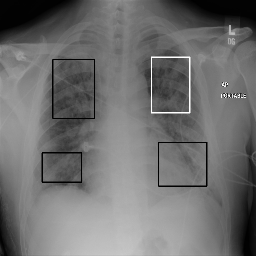

In [ ]:
show_duplicates_bb(dup_df,-1,pid_max)

## Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 12.5 MB/s 


In [ ]:
import pydicom as dcm

In [ ]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, random, csv
import seaborn as sns
from glob import glob
from tqdm import tqdm
%matplotlib inline

# MODEL METRICS
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split

# SET VARIABLES
PATH = '/content/drive/MyDrive/capstone/'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH+'')
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + '')
MODEL_WEIGHTS = os.path.join(PATH + 'model_weights/')
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR + 'stage_2_train_images_png/')
if not os.path.exists(TRAIN_IMAGES_DIR): os.makedirs(TRAIN_IMAGES_DIR)
if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

# CUSTOM MODULE
from module.classify import *

# SET RANDOM SEED
random_state = 2020
random.seed(random_state)
np.random.seed(random_state)

# USE GPU FOR MODEL TRAINING
config = tf.compat.v1.ConfigProto(log_device_placement = True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)
list_gpu = tf.config.experimental.list_physical_devices(device_type = 'GPU')
if len(list_gpu)==1: strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else: strategy = tf.distribute.MirroredStrategy()
print('Num GPUs Available: ', len(list_gpu))
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7

Num GPUs Available:  1
Mixed precision enabled


## Read Data & Prep for Model
* Read a pickle file that was saved as part of [EDA & Data Prep]

In [ ]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle(OUTPUT_DIR + 'train_feature_engineered.pkl')
display(train_class.shape, train_class.head())

(30227, 16)

,patientId,x,y,width,height,Target,class,y_max,x_max,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality,number_of_boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,51.0,CHEST,PA,CR,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,48.0,CHEST,PA,CR,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,19.0,CHEST,AP,CR,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,28.0,CHEST,PA,CR,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,/content/drive/MyDrive/capstone/stage_2_train_...,F,32.0,CHEST,AP,CR,2


In [ ]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [ ]:
# Run only if you haven't converted to png images yet
#print('Convert dicom to png images'); print('--'*40)
from tqdm.notebook import tqdm
import cv2
image_lists = [f for f in os.listdir(TRAIN_IMAGES)]
for f in tqdm(image_lists): 
    ds = dcm.read_file(TRAIN_IMAGES + f)
    img = ds.pixel_array
    cv2.imwrite(TRAIN_IMAGES_DIR + f.replace('.dcm','.png'), img)
image_lists[0]

  0%|          | 0/26684 [00:00<?, ?it/s]

'f7b6c4f3-b7ea-43e5-a4b8-8e893e877ccd.dcm'

In [ ]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_target['path'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


In [ ]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 3)
VALID:(2668, 3)
TEST:(2668, 3)


In [ ]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(df_train['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

In [ ]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle(OUTPUT_DIR + 'train_data.pkl')
df_valid.to_pickle(OUTPUT_DIR + 'valid_data.pkl')
df_test.to_pickle(OUTPUT_DIR + 'test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


## Model - DenseNet121

In [ ]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision, f1_score]

In [ ]:
df_train['Target'] = df_train['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [ ]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = BATCH_SIZE, 
                            path = TRAIN_IMAGES_DIR, 
                            img_size = (IMAGE_SIZE, IMAGE_SIZE), 
                            class_mode = 'binary',
                            random_state = random_state)

Create generators for training, validation and test dataframes
--------------------------------------------------------------------------------
Train Generator Created ----------------------------------------
Found 21347 validated image filenames belonging to 2 classes.
Validation Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.
Test Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.


In [ ]:
def build_model():
    print('Create a `DenseNet121` model'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'DenseNet121')
    
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    
    callbacks = [cp, csv_logger, lrscheduler]
    return callbacks

In [ ]:
print('Lets fit the model.....')
K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks = callbacks()
    train_generator = generators.train_generator
    validation_generator = generators.valid_generator
    test_generator = generators.test_generator    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = generators.step_size_train,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks,
                                  validation_data = validation_generator, 
                                  validation_steps = generators.step_size_valid)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `DenseNet121` model
--------------------------------------------------------------------------------
29097984/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseNet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
No

In [ ]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

In [ ]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy, ap, f1 = model.evaluate_generator(generator = validation_generator, 
                                          steps = generators.step_size_valid)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}, AP: {round(float(ap), 3)}, F1 Score: {round(float(f1), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.338, Accuracy: 0.843, AP: 0.665, F1 Score: 0.612


In [ ]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         steps = generators.step_size_valid,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
84/84 [==============================] - 37s 415ms/step


In [ ]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                                        steps = generators.step_size_test,
                                        verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

In [ ]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.890


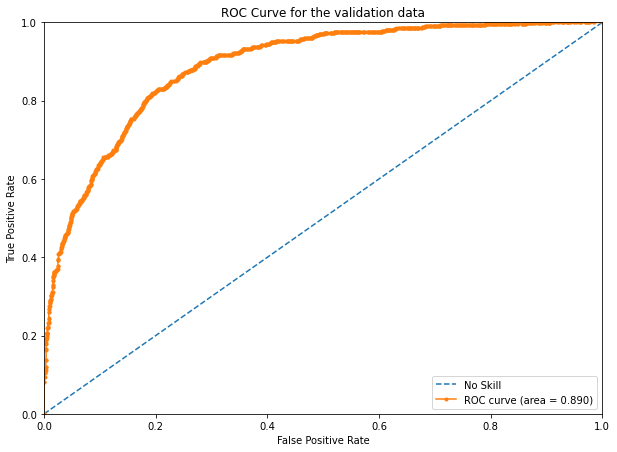

In [ ]:
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.894


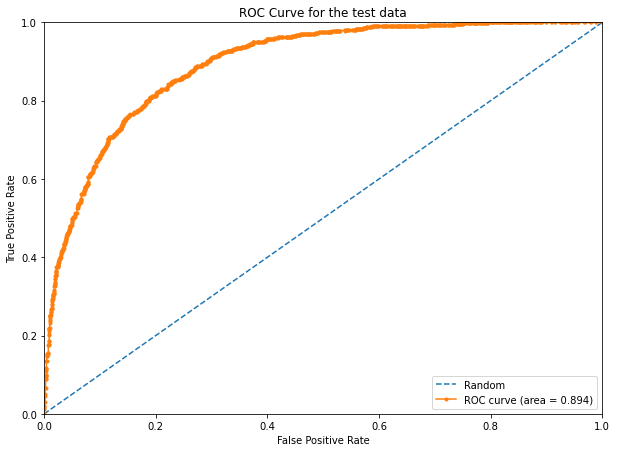

In [ ]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


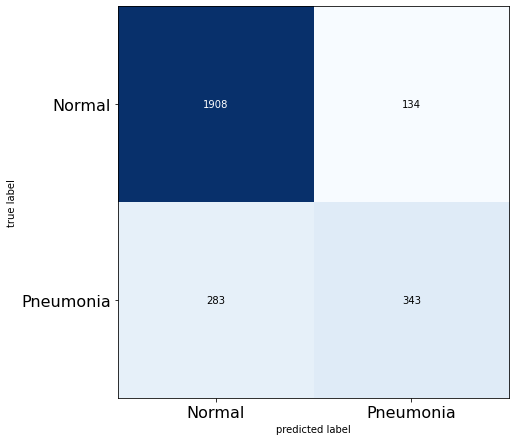

In [ ]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [ ]:
print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.87      0.93      0.90      2042
   Pneumonia       0.72      0.55      0.62       626

    accuracy                           0.84      2668
   macro avg       0.79      0.74      0.76      2668
weighted avg       0.84      0.84      0.84      2668



## Model - DenseNet121 + CheXNet pre-trained weights
Acknowledgement for the pre-trained weights:
We used pre-trained weights available from the following [repository](https://github.com/brucechou1983/CheXNet-Keras).

In [ ]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = 224
EPOCH = 10
LEARNING_RATE = 1e-3
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_chexnet.h5'
FINAL_MODEL = 'best_chexnet_final.h5'
LOG_FILE = 'logs_chexnet.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy', average_precision, f1_score]

In [ ]:
print('Create generators for training, validation and test dataframes'); print('--'*40)
generators = DataGenerators(df_train, df_valid, df_test, 
                            batch_size = BATCH_SIZE, 
                            path = TRAIN_IMAGES_DIR, 
                            img_size = (IMAGE_SIZE, IMAGE_SIZE), 
                            class_mode = 'binary',
                            random_state = random_state)

Create generators for training, validation and test dataframes
--------------------------------------------------------------------------------
Train Generator Created ----------------------------------------
Found 21348 validated image filenames belonging to 2 classes.
Validation Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.
Test Generator Created ----------------------------------------
Found 2668 validated image filenames belonging to 2 classes.


In [ ]:
def build_model():
    print('Create a `CheXNet-like` model using pre-trained weights'); print('--'*40)
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = True, input_tensor = inputs, weights = MODEL_WEIGHTS + 'CheXNet weights.h5', classes = 14)
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-2].output, name = 'CheXNet-like')
    
    model = Sequential(name = 'CheXNet-like')
    model.add(densenet)
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    
    callbacks = [cp, csv_logger, lrscheduler]
    return callbacks

In [ ]:
print('Lets fit the model.....')
K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks = callbacks()
    train_generator = generators.train_generator
    validation_generator = generators.valid_generator
    test_generator = generators.test_generator    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = generators.step_size_train,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks,
                                  validation_data = validation_generator, 
                                  validation_steps = generators.step_size_valid)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `CheXNet-like` model using pre-trained weights
--------------------------------------------------------------------------------
Model: "CheXNet-like"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CheXNet-like (Model)         (None, 1024)              7037504   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 7,038,529
Trainable params: 6,954,881
Non-trainable params: 83,648
_________________________________________________________________
Train for 668 steps, validate for 84 steps
Epoch 1/10
667/668 [============================>.] - ETA: 0s - loss: 0.3733 - accuracy: 0.8300 - average_precision: 0.6600 - f1_score: 0.5311
Epoch 00001: val_loss 

In [ ]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [ ]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy, ap, f1 = model.evaluate_generator(generator = validation_generator, 
                                          steps = generators.step_size_valid)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}, AP: {round(float(ap), 3)}, F1 Score: {round(float(f1), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.325, Accuracy: 0.848, AP: 0.692, F1 Score: 0.61


In [ ]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         steps = generators.step_size_valid,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
84/84 [==============================] - 26s 314ms/step


In [ ]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                                        steps = generators.step_size_test,
                                        verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 26s 311ms/step


In [ ]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.898


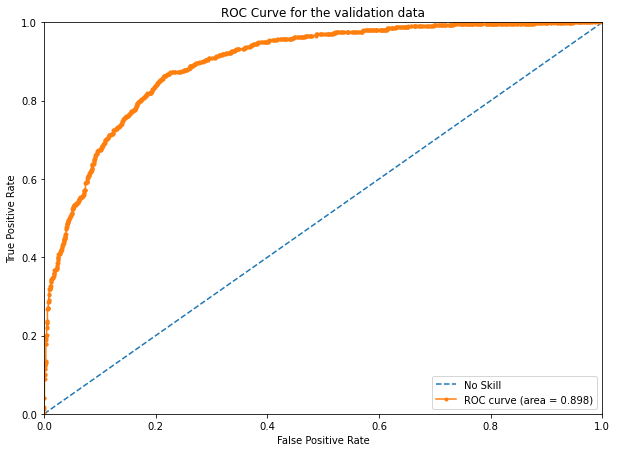

In [ ]:
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.895


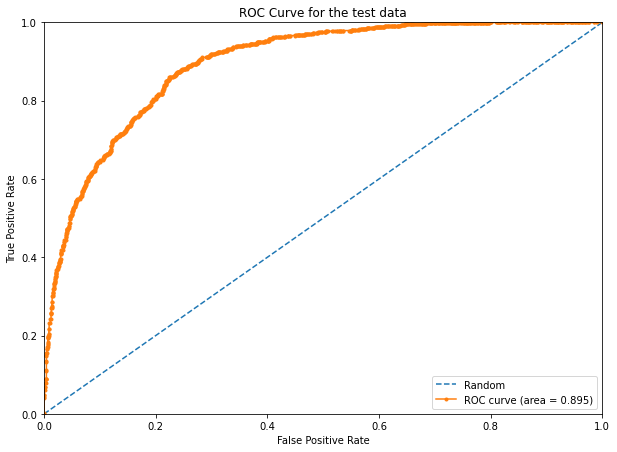

In [ ]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


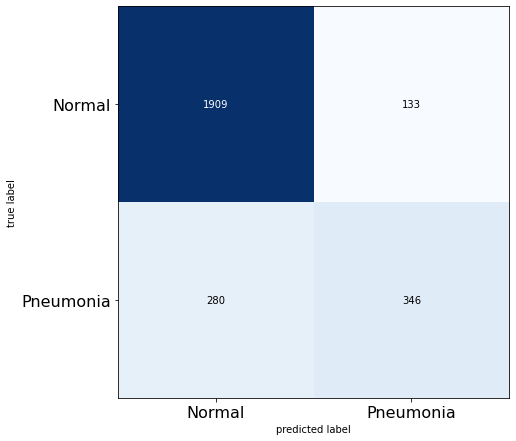

In [ ]:
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [ ]:
print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.87      0.93      0.90      2042
   Pneumonia       0.72      0.55      0.63       626

    accuracy                           0.85      2668
   macro avg       0.80      0.74      0.76      2668
weighted avg       0.84      0.85      0.84      2668



Train/Validation Accuracy/Loss Comparison
--------------------------------------------------------------------------------


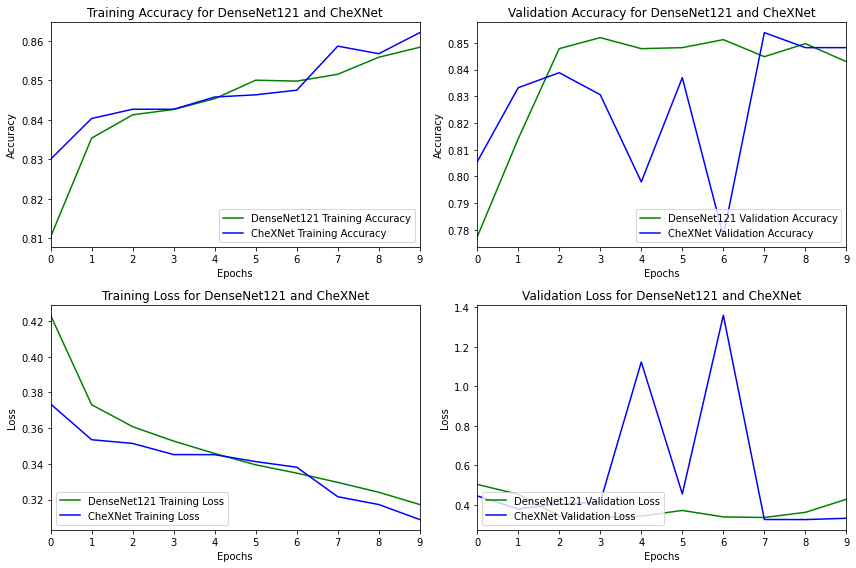

In [ ]:
print('Train/Validation Accuracy/Loss Comparison'); print('--'*40)
logs = pd.read_csv(MODEL_WEIGHTS + 'logs.csv')
logs_chex = pd.read_csv(MODEL_WEIGHTS + 'logs_chexnet.csv')
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8))

ax1.plot(logs['epoch'], logs['accuracy'], 'g', label = 'DenseNet121 Training Accuracy')
ax1.plot(logs_chex['epoch'], logs_chex['accuracy'], 'b', label = 'CheXNet Training Accuracy')
ax1.set_title('Training Accuracy for DenseNet121 and CheXNet')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(0, logs['epoch'].max())
# ax1.set_ylim(0, 1)
ax1.legend(loc = 'lower right')

ax2.plot(logs['epoch'], logs['val_accuracy'], 'g', label = 'DenseNet121 Validation Accuracy')
ax2.plot(logs_chex['epoch'], logs_chex['val_accuracy'], 'b', label = 'CheXNet Validation Accuracy')
ax2.set_title('Validation Accuracy for DenseNet121 and CheXNet')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_xlim(0, logs['epoch'].max())
# ax2.set_ylim(0, 1)
ax2.legend(loc = 'lower right')

ax3.plot(logs['epoch'], logs['loss'], 'g', label = 'DenseNet121 Training Loss')
ax3.plot(logs_chex['epoch'], logs_chex['loss'], 'b', label = 'CheXNet Training Loss')
ax3.set_title('Training Loss for DenseNet121 and CheXNet')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Loss')
ax3.set_xlim(0, logs['epoch'].max())
# ax3.set_ylim(0, logs['loss'].max())
ax3.legend(loc = 'lower left')

ax4.plot(logs['epoch'], logs['val_loss'], 'g', label = 'DenseNet121 Validation Loss')
ax4.plot(logs_chex['epoch'], logs_chex['val_loss'], 'b', label = 'CheXNet Validation Loss')
ax4.set_title('Validation Loss for DenseNet121 and CheXNet')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Loss')
ax4.set_xlim(0, logs['epoch'].max())
# ax4.set_ylim(0, logs['val_loss'].max())
ax4.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 1280)        0         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               32113152  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                      

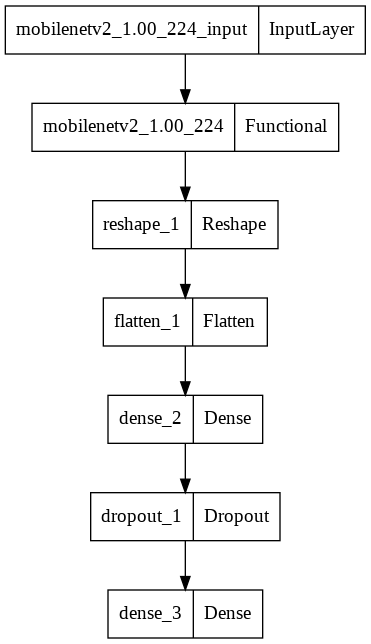

In [ ]:
#MobileNetV2 model for Pneumnia deep learning detection
import numpy as np
import keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.applications import MobileNetV2
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.preprocessing.image import ImageDataGenerator
import os
import zipfile
import tensorflow as tf
import numpy as np
import keras
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D,AveragePooling2D# convolution layers
from keras.layers import Dense, Dropout, Flatten,Activation,Reshape # core layers1
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
def createModel(): #MobileNetV2 model for Pneumnia deep learning detection
   top_model = Sequential()
   top_model.add(MobileNetV2(include_top=False,weights="imagenet",
                             input_shape=(224,224,3)))
   top_model.add(Reshape((7,7,1280), input_shape=(-1,7,7,1280)))
   top_model.add(Flatten())
   top_model.add(Dense(512, activation='relu'))
   top_model.add(Dropout(0.5))
   top_model.add(Dense(1, activation='sigmoid'))
   return top_model
model8 = createModel()

model8.summary()
#plot the model as a graph
keras.utils.plot_model(model8, "mobilenet_model.png")

In [ ]:
#Optimizer and fit function
from tensorflow.keras.optimizers import RMSprop, Adamax
import tensorflow as tf
from tensorflow import keras

import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]
opt = Adamax(lr= 0.00006, beta_1=0.9, beta_2=0.999, epsilon=1e-07)   

#adam = Adam(lr=0.0001), momentum=0.9 Adamax(lr= 0.00045, beta_1=0.9, beta_2=0.999, epsilon=1e-07)  
#opt = keras.optimizers.Adam(learning_rate=0.07)
#model.compile(loss='categorical_crossentropy', optimizer=opt)

model8.compile(loss='binary_crossentropy',
              optimizer= opt,
              metrics=METRICS)

train_generator = generators.train_generator
validation_generator = generators.valid_generator
test_generator = generators.test_generator    

checkpoint_path = "mobilenet_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model8.fit(
      train_generator,
      steps_per_epoch=32,
      epochs=15,
      verbose=1,
      validation_data = validation_generator,
     callbacks=[cp_callback],
      validation_steps=8) 
      

#Save and serialize
model8.save("path_model_mobilenetv2")
model8.save('model_mobilenetv2.h5')
print('model model_mobilenetv2 saved!!!!!')

Epoch 1/15
32/32 [==============================] - ETA: 0s - loss: 0.4968 - tp: 93.0000 - fp: 84.0000 - tn: 719.0000 - fn: 128.0000 - accuracy: 0.7930 - precision: 0.5254 - recall: 0.4208 - auc: 0.7959
Epoch 1: saving model to mobilenet_training/cp.ckpt
32/32 [==============================] - 193s 6s/step - loss: 0.4968 - tp: 93.0000 - fp: 84.0000 - tn: 719.0000 - fn: 128.0000 - accuracy: 0.7930 - precision: 0.5254 - recall: 0.4208 - auc: 0.7959 - val_loss: 1.3388 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 204.0000 - val_fn: 52.0000 - val_accuracy: 0.7969 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000
Epoch 2/15
32/32 [==============================] - ETA: 0s - loss: 0.4165 - tp: 130.0000 - fp: 70.0000 - tn: 713.0000 - fn: 111.0000 - accuracy: 0.8232 - precision: 0.6500 - recall: 0.5394 - auc: 0.8401
Epoch 2: saving model to mobilenet_training/cp.ckpt
32/32 [==============================] - 184s 6s/step - loss: 0.4165 - tp: 130.0000 - fp: 70.0000 - 

model model_mobilenetv2 saved!!!!!


## Part 3: Modelling & Predicting Pneumonia w/ Neural Networks

In [ ]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd "/content/drive/MyDrive/capstone"

/content/drive/MyDrive/capstone


In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 5.4 MB/s 


In [ ]:
# Imports
import os
import cv2
import glob
import time
import pydicom
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [ ]:
# Reference image directories
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

labelsPath = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"

# Read labels and classinfo
labels = pd.read_csv(labelsPath)
details = pd.read_csv(classInfoPath)

## Part 3.1: Attaining our Training & Testing Data in Proper Format

In [ ]:
"""
@Description: Reads an array of dicom image paths, and returns an array of the images after they have been read

@Inputs: An array of filepaths for the images

@Output: Returns an array of the images after they have been read
"""
def readDicomData(data):
    
    res = []
    
    for filePath in tqdm(data): # Loop over data
        
        # Using stop_before_pixels to avoid reading the image (Saves on speed/memory)
        f = pydicom.read_file(filePath, stop_before_pixels=True)
        res.append(f)
    
    return res

In [ ]:
# Creating an array of the test & training file paths
trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

# Reading data into an array
trainImages = readDicomData(trainFilepaths[:5000])
testImages = readDicomData(testFilepaths[:3000])

100%|██████████| 3000/3000 [12:12<00:00,  4.10it/s]


## Part 3.2: Balancing our Data

We balance our data as CNNs work best on evenly balanced data

In [ ]:
COUNT_NORMAL = len(labels.loc[labels['Target'] == 0]) # Number of patients with no pneumonia
COUNT_PNE = len(labels.loc[labels['Target'] == 1]) # Number of patients with pneumonia
TRAIN_IMG_COUNT = len(trainFilepaths) # Total patients

# Calculating the weight of each
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNE)*(TRAIN_IMG_COUNT)/2.0

classWeight = {0: weight_for_0, 
               1: weight_for_1}

print(f"Weights: {classWeight}")

Weights: {0: 0.6454140866873065, 1: 1.3963369963369963}


## Part 3.3: Get Train_Y & Test_Y

In [ ]:
"""
@Description: This function parses the medical images meta-data contained

@Inputs: Takes in the dicom image after it has been read

@Output: Returns the unpacked data and the group elements keywords
"""
def parseMetadata(dcm):
    
    unpackedData = {}
    groupElemToKeywords = {}
    
    for d in dcm: # Iterating to force conversion from lazy RawDataElement to DataElement
        pass
    
    # Un-pack Data
    for tag, elem in dcm.items():
        tagGroup = tag.group
        tagElem = tag.elem
        keyword = elem.keyword
        groupElemToKeywords[(tagGroup, tagElem)] = keyword
        value = elem.value
        unpackedData[keyword] = value
        
    return unpackedData, groupElemToKeywords

In [ ]:
# Parsing metadata into dictionaries
trainMetaDicts, trainKeyword = zip(*[parseMetadata(x) for x in tqdm(trainImages)])
testMetaDicts, testKeyword = zip(*[parseMetadata(x) for x in tqdm(testImages)])

100%|██████████| 3000/3000 [00:03<00:00, 862.77it/s] 


In [ ]:
"""
@Description: This function goes through the dicom image information and returns 1 or 0
              depending on whether the image contains Pneumonia or not

@Inputs: A dataframe containing the metadata

@Output: Returns the Y result (i.e: our train and test y)
"""
def createY(df):
    y = (df['SeriesDescription'] == 'view: PA')
    Y = np.zeros(len(y)) # Initialise Y
    
    for i in range(len(y)):
        if(y[i] == True):
            Y[i] = 1
    
    return Y


train_df = pd.DataFrame.from_dict(data=trainMetaDicts)
test_df = pd.DataFrame.from_dict(data=testMetaDicts)

train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

df = train_df
df2 = test_df

train_Y = createY(df) # Create training Y 
test_Y = createY(df2) # Create testing Y

## Part 3.4: Get Train_X & Test_X

In [ ]:
"""
@Description: This decodes an image by reading the pixel array, resizing it into the correct format and
              normalising the pixels

@Inputs:
    - filePath: This is the filepath of the image that we want to decode

@Output:
    - img: This is the image after it has been decoded
"""
def decodeImage(filePath):
    image = pydicom.read_file(filePath).pixel_array
    image = cv2.resize(image, (128, 128))
    return (image/255)

In [ ]:
# Get our train x in the correct shape
train_X = []

for filePath in tqdm(trainFilepaths[:5000]):
    
    img = decodeImage(filePath)
    train_X.append(img)

train_X = np.array(train_X) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 5000/5000 [00:58<00:00, 85.97it/s]


In [ ]:
# Get our test x in the correct shape for NN
test_X = []

for filePath in tqdm(testFilepaths):
    img_test = decodeImage(filePath) # Decode & Resize
    test_X.append(img_test)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 3000/3000 [00:34<00:00, 86.19it/s]


In [ ]:
"""
@Description: This function plots our metrics for our models across epochs

@Inputs: The history of the fitted model

@Output: N/A
"""
def plottingScores(hist):
    fig, ax = plt.subplots(1, 5, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'precision', 'recall', 'AUC', 'loss']):
        ax[i].plot(hist.history[met])
        ax[i].plot(hist.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

## Part 3.5: Metrics Evaluation
For our metrics, we want to include <b><i>precision</i></b> and <b><i>recall</i></b> as they will provide use with more info on how good our model is
 
 
- <b><u>Accuracy:</u></b> This tells us what fraction of the labels are correct.
    - Since our data is not balanced, accuracy might give a skewed sense of a good model


- <b><u>Precision:</u></b> This tells us the number of true positives (TP) over the sum of TP and false positives (FP). 
    - It shows what fraction of labeled positives are actually correct.


- <b><u>Recall:</u></b> The number of TP over the sum of TP and false negatves (FN). 
    - It shows what fraction of actual positives are correct.

In [ ]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='AUC')]

### Tuning our Models with Callbacks

- We'll use Keras callbacks to further finetune our model. 
- The <b>checkpoint callback</b> saves the best weights of the model, so next time we want to use the model, we do not have to spend time training it. 
- The <b>early stopping callback</b> stops the training process when the model starts becoming stagnant, or even worse, when the model starts overfitting. 
- Since we set restore_best_weights to True, the returned model at the end of the training process will be the model with the best weights (i.e. low loss and high accuracy).

In [ ]:
# Define our callback functions to pass when fitting our NNs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

## Part 3.6: Building Model #1 - Fully Connected Model

In [ ]:
"""
@Description: This function builds our simple Fully-connected NN

@Inputs: N/A

@Output: Returns the FCNN Model
"""
def build_fcnn_model():
    
    # Basic model with a flattening layer followng by 2 dense layers
    # The first dense layer is using relu and the 2nd one is using sigmoid
    model = tf.keras.models.Sequential([
                tf.keras.layers.Flatten(input_shape = (128, 128, 3)), 
                tf.keras.layers.Dense(128, activation = "relu"), 
                tf.keras.layers.Dense(1, activation = "sigmoid")
                ])
    
    return model

In [ ]:
# Building our FCNN model and compile
model_fcnn = build_fcnn_model()
model_fcnn.summary()
model_fcnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=METRICS) # Compile

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6291584   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 6,291,713
Trainable params: 6,291,713
Non-trainable params: 0
_________________________________________________________________


### Fitting Model to Training Data

In [ ]:
history_fcnn = model_fcnn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 30,
                          batch_size = 128,
                          validation_split = 0.2, 
                          class_weight = classWeight, 
                          verbose = 1,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit the model

Epoch 1/30
32/32 [==============================] - 1s 35ms/step - loss: 0.2036 - accuracy: 0.9103 - precision: 0.8935 - recall: 0.9500 - AUC: 0.9718 - val_loss: 0.2231 - val_accuracy: 0.9260 - val_precision: 0.9652 - val_recall: 0.8922 - val_AUC: 0.9703 - lr: 0.0100
Epoch 2/30
32/32 [==============================] - 1s 30ms/step - loss: 0.2194 - accuracy: 0.8997 - precision: 0.8799 - recall: 0.9468 - AUC: 0.9679 - val_loss: 0.2154 - val_accuracy: 0.9210 - val_precision: 0.9018 - val_recall: 0.9546 - val_AUC: 0.9801 - lr: 0.0089
Epoch 3/30
32/32 [==============================] - 2s 78ms/step - loss: 0.1839 - accuracy: 0.9145 - precision: 0.8929 - recall: 0.9595 - AUC: 0.9785 - val_loss: 0.2110 - val_accuracy: 0.9280 - val_precision: 0.9770 - val_recall: 0.8847 - val_AUC: 0.9767 - lr: 0.0079
Epoch 4/30
32/32 [==============================] - 1s 30ms/step - loss: 0.1833 - accuracy: 0.9193 - precision: 0.9046 - recall: 0.9536 - AUC: 0.9775 - val_loss: 0.2242 - val_accuracy: 0.9100 - va

94/94 [==============================] - 1s 8ms/step - loss: 0.1902 - accuracy: 0.9387 - precision: 0.9410 - recall: 0.9456 - AUC: 0.9797
{'loss': 0.19015023112297058, 'accuracy': 0.9386666417121887, 'precision': 0.9409593939781189, 'recall': 0.9456118941307068, 'AUC': 0.9796670079231262}


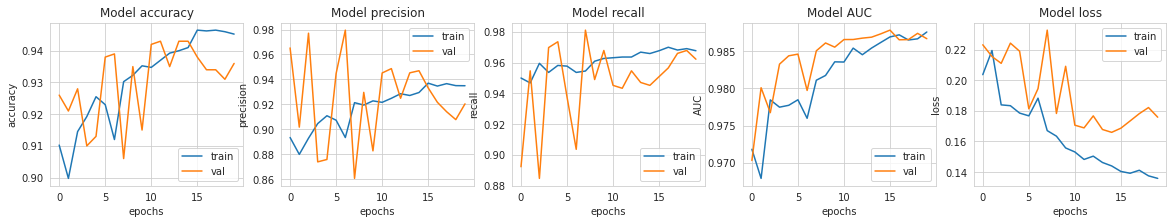

In [ ]:
# Evaluate and display results
results = model_fcnn.evaluate(test_X_rgb, test_Y) # Evaluate the model on test data
results = dict(zip(model_fcnn.metrics_names,results))

print(results)
plottingScores(history_fcnn) # Visualise scores

## Part 3.7: Building Model #2 - CNN

In our CNN model, fewer parameters are needed because every convolutional layer reduces the dimensions of the input through the convolution operation.

In [ ]:
"""
@Description: This function builds our custom CNN Model

@Inputs: N/A

@Output: Returns the CNN model
"""
def build_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu', input_shape=(128, 128, 3)), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), strides=(1,1), padding = 'valid', activation = 'relu'), #  convolutional layer
        tf.keras.layers.MaxPool2D(pool_size=(2,2)), # flatten output of conv
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'valid'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(), # flatten output of conv
        tf.keras.layers.Dense(512, activation = "relu"), # hidden layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation = "relu"), #  output layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation = "sigmoid")])
    
    return model

In [ ]:
# Building and compiling model
model_cnn = build_cnn_model()
model_cnn.summary()
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)       

In [ ]:
# Fit model
history_cnn = model_cnn.fit(train_X_rgb, 
                      train_Y,  
                      epochs=30, 
                      validation_split = 0.15, 
                      batch_size=128,
                      class_weight=classWeight,
                      callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
                      verbose=1) # Fit the model

Epoch 1/30
34/34 [==============================] - 6s 176ms/step - loss: 0.1398 - accuracy: 0.9424 - precision: 0.9316 - recall: 0.9657 - AUC: 0.9852 - val_loss: 1.2117 - val_accuracy: 0.7680 - val_precision: 0.9912 - val_recall: 0.5678 - val_AUC: 0.9022 - lr: 0.0100
Epoch 2/30
34/34 [==============================] - 6s 169ms/step - loss: 0.1041 - accuracy: 0.9553 - precision: 0.9451 - recall: 0.9751 - AUC: 0.9914 - val_loss: 0.6969 - val_accuracy: 0.8107 - val_precision: 0.9706 - val_recall: 0.6633 - val_AUC: 0.9240 - lr: 0.0089
Epoch 3/30
34/34 [==============================] - 6s 167ms/step - loss: 0.0754 - accuracy: 0.9704 - precision: 0.9646 - recall: 0.9820 - AUC: 0.9948 - val_loss: 0.7756 - val_accuracy: 0.7107 - val_precision: 0.6558 - val_recall: 0.9573 - val_AUC: 0.8844 - lr: 0.0079
Epoch 4/30
34/34 [==============================] - 6s 166ms/step - loss: 0.0815 - accuracy: 0.9659 - precision: 0.9565 - recall: 0.9824 - AUC: 0.9940 - val_loss: 0.7644 - val_accuracy: 0.7467 

94/94 [==============================] - 2s 22ms/step - loss: 0.1554 - accuracy: 0.9480 - precision: 0.9873 - recall: 0.9153 - AUC: 0.9911
{'loss': 0.15537382662296295, 'accuracy': 0.9480000138282776, 'precision': 0.987333357334137, 'recall': 0.9153275489807129, 'AUC': 0.9910994172096252}


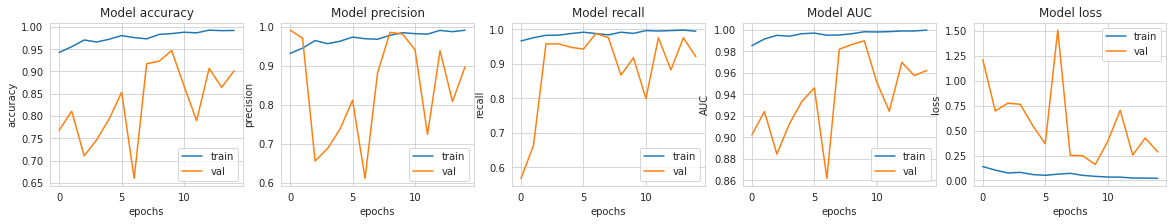

In [ ]:
# Evaluating models results and put them into a dict
results = model_cnn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_cnn.metrics_names,results))

print(results)
plottingScores(history_cnn) # Visualise scores

## Part 3.8: Building Model #3 - Mobile Net with Transfer Learning

In [ ]:
"""
@Description: This function builds our MobileNet Model

@Inputs: N/A

@Output: Returns the Mobile Net model
"""
def build_mn_model():
    
    model = tf.keras.Sequential([
        tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3)),
        tf.keras.layers.GlobalAveragePooling2D(),
        Dense(1, activation = 'sigmoid')
    ])
    
    model.layers[0].trainable = False
    
    return model

In [ ]:
# Building and compiling mobile net model
model_mn = build_mn_model()
model_mn.summary()
model_mn.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
history_mn = model_mn.fit(train_X_rgb, 
                          train_Y,  
                          epochs = 30, 
                          validation_split = 0.20, 
                          class_weight = classWeight,
                          batch_size = 64,
                          callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler])

Epoch 1/30
63/63 [==============================] - 16s 180ms/step - loss: 0.2324 - accuracy: 0.8985 - precision: 0.9228 - recall: 0.9306 - AUC: 0.9752 - val_loss: 0.0689 - val_accuracy: 0.9780 - val_precision: 0.9738 - val_recall: 0.9849 - val_AUC: 0.9969 - lr: 0.0100
Epoch 2/30
63/63 [==============================] - 7s 117ms/step - loss: 0.0509 - accuracy: 0.9793 - precision: 0.9736 - recall: 0.9891 - AUC: 0.9981 - val_loss: 0.0526 - val_accuracy: 0.9820 - val_precision: 0.9794 - val_recall: 0.9868 - val_AUC: 0.9981 - lr: 0.0089
Epoch 3/30
63/63 [==============================] - 7s 109ms/step - loss: 0.0354 - accuracy: 0.9872 - precision: 0.9851 - recall: 0.9918 - AUC: 0.9990 - val_loss: 0.0593 - val_accuracy: 0.9820 - val_precision: 0.9723 - val_recall: 0.9943 - val_AUC: 0.9975 - lr: 0.0079
Epoch 4/30
63/63 [==============================] - 8s 121ms/step - loss: 0.0274 - accuracy: 0.9925 - precision: 0.9896 - recall: 0.9968 - AUC: 0.9993 - val_loss: 0.0498 - val_accuracy: 0.9870

94/94 [==============================] - 5s 50ms/step - loss: 0.0538 - accuracy: 0.9870 - precision: 0.9858 - recall: 0.9901 - AUC: 0.9963
{'loss': 0.0538092665374279, 'accuracy': 0.9869999885559082, 'precision': 0.9858461618423462, 'recall': 0.990111231803894, 'AUC': 0.9962998032569885}


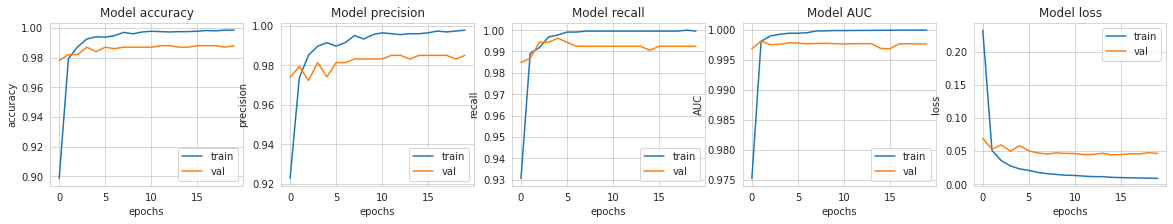

In [ ]:
# Show results and print graphs
results = model_mn.evaluate(test_X_rgb, test_Y)
results = dict(zip(model_mn.metrics_names,results))

print(results)
plottingScores(history_mn) # Visualise scores

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model_mn.predict_classes(test_X_rgb)
confusion_matrix(test_Y, y_pred)

AttributeError: ignored

### Function to Perform K-Fold CV

In [ ]:
import gc

In [ ]:
"""
@Description: This function performs K-Fold Cross Validation with a provided Deep Learning Model

@Inputs:
    - K: Number of folds
    - build_model_func: Function to create model
    - epochs: Number of epochs to train data
    - batchSize: Batch size when fitting the model

@Output: Dict of metric results from K-fold CV
"""
def performCV(K, build_model_func, epochs, batchSize):
    
    kfold = KFold(n_splits = K, shuffle = True) # Split data into K Folds
    
    res = {
        'acc_per_fold': [],
        'precision_per_fold': [],
        'recall_per_fold': [],
        'auc_per_fold': [],
        'loss_per_fold': []
    }

    fold_no = 1

    for train_index, test_index in kfold.split(train_X_rgb):

        X_train, X_test = train_X_rgb[train_index], train_X_rgb[test_index] # Split data
        y_train, y_test = train_Y[train_index], train_Y[test_index]

        model = build_model_func() # Build model
        mets = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='AUC')]

        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=mets) # Compile our model

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Train the model on the current fold
        history = model.fit(X_train,
                            y_train, 
                            epochs = epochs,
                            batch_size = batchSize,
                            class_weight = classWeight,
                            callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler]) # Fit data to model

        scores = model.evaluate(X_test, y_test, verbose=0) # Evalute the model

        print(f'Scores for fold {fold_no}:')
        print(f'{model.metrics_names[0]}: {scores[0]}')
        print(f'{model.metrics_names[1]}: {scores[1]*100}%')
        print(f'{model.metrics_names[2]}: {scores[2]*100}%')
        print(f'{model.metrics_names[3]}: {scores[3]*100}%')

        res['loss_per_fold'].append(scores[0])
        res['acc_per_fold'].append(scores[1] * 100)
        res['precision_per_fold'].append(scores[2]*100)
        res['recall_per_fold'].append(scores[3]*100)
        res['auc_per_fold'].append(scores[4]*100)

        gc.collect()
        # Increase fold number
        fold_no += 1
    
    return res # return our results dict

## Part 3.9: K-Fold Cross Validation with all 3 Networks

In [ ]:
# Full-connected NN
resFCNN = performCV(5, build_fcnn_model, 30, 128)

In [ ]:
# Convolutional NN
resCNN = performCV(5, build_cnn_model, 30, 64)

In [ ]:
# MobileNet
resMB = performCV(5, build_mn_model, 30, 64)

In [ ]:
resMB

## Import Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 7.3 MB/s 


In [ ]:
import pydicom as dcm

In [ ]:
# IMPORT PACKAGES
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, random, csv
import seaborn as sns
from glob import glob
from tqdm import tqdm
%matplotlib inline

import tensorflow as tf
import tensorflow.keras as keras

# MODEL METRICS
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input

from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input 

# SET VARIABLES
PATH = '/content/drive/MyDrive/capstone'
os.chdir(PATH)

DATA_DIR = os.path.join(PATH+'/')
TRAIN_IMAGES = os.path.join(DATA_DIR + 'stage_2_train_images/')
TEST_IMAGES = os.path.join(DATA_DIR + 'stage_2_test_images/')
OUTPUT_DIR = os.path.join(PATH + '')
MODEL_WEIGHTS = os.path.join(PATH + 'model_weights/')
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR + 'stage_2_train_images_png/')
#if not os.path.exists(TRAIN_IMAGES_DIR): os.makedirs(TRAIN_IMAGES_DIR)
#if not os.path.exists(MODEL_WEIGHTS): os.makedirs(MODEL_WEIGHTS)

# CUSTOM MODULE
#from module.classify import *

# SET RANDOM SEED
random_state = 2020
random.seed(random_state)
np.random.seed(random_state)

# USE GPU FOR MODEL TRAINING
config = tf.compat.v1.ConfigProto(log_device_placement = True, allow_soft_placement = True)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config = config)
list_gpu = tf.config.experimental.list_physical_devices(device_type = 'GPU')
if len(list_gpu)==1: strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
else: strategy = tf.distribute.MirroredStrategy()
print('Num GPUs Available: ', len(list_gpu))
tf.config.optimizer.set_experimental_options({'auto_mixed_precision': True})
print('Mixed precision enabled')

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0

Num GPUs Available:  1
Mixed precision enabled


## Read Data & Prep for Model
* Read a pickle file that was saved as part of [EDA & Data Prep]

In [ ]:
# Read `train_class_features.pkl` file, saved as EDA & Data Prep Module
train_class = pd.read_pickle('/content/drive/MyDrive/train_feature_engineered.pkl')
display(train_class.shape, train_class.head())

(30227, 16)

,patientId,x,y,width,height,Target,class,y_max,x_max,path,PatientSex,PatientAge,BodyPartExamined,ViewPosition,Modality,number_of_boxes
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,51.0,CHEST,PA,CR,1
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,F,48.0,CHEST,PA,CR,1
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,19.0,CHEST,AP,CR,1
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,NaN,NaN,/content/drive/MyDrive/capstone/stage_2_train_...,M,28.0,CHEST,PA,CR,1
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,531.0,477.0,/content/drive/MyDrive/capstone/stage_2_train_...,F,32.0,CHEST,AP,CR,2


In [ ]:
# A dataframe with paths, classes and targets
print('Prepare a dataframe with paths, classes and targets'); print('--'*40)
path_class_target = train_class[['patientId', 'path', 'class', 'Target']].copy(deep = True)
path_class_target['path'] = (path_class_target['path']
                             .str.replace('stage_2_train_images', 'stage_2_train_images_png')
                             .str.replace('.dcm', '.png'))
path_class_target.drop_duplicates(inplace = True)
display(path_class_target.shape, path_class_target.nunique())
print('\nDistribution of target and classes')
display(path_class_target['Target'].value_counts())
print()
display(path_class_target['class'].value_counts())

Prepare a dataframe with paths, classes and targets
--------------------------------------------------------------------------------


(26684, 4)

patientId    26684
path         26684
class            3
Target           2
dtype: int64


Distribution of target and classes


0    20672
1     6012
Name: Target, dtype: int64

No Lung Opacity / Not Normal    11821
Normal                           8851
Lung Opacity                     6012
Name: class, dtype: int64

In [ ]:
#print("\n".join(path_class_target['path'].to_list()))

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
class_enc = LabelEncoder()
#path_class_target['class_idx'] = class_enc.fit_transform(path_class_target['class'])
#oh_enc = OneHotEncoder(sparse=False)
#path_class_target['class_vec'] = oh_enc.fit_transform(
 #   path_class_target['class_idx'].values.reshape(-1, 1)).tolist() 
#path_class_target.sample(3)

In [ ]:
# Split the data in train, valid and test sets
print('Split the data in train, valid and test sets'); print('--'*40)

image_list = list(path_class_target['path'])
random.shuffle(image_list)
val_size = round(len(image_list)/10)
test_size = round(len(image_list)/10)
train_size = len(image_list)-test_size-val_size

X_train = image_list[:train_size]
X_valid = image_list[train_size:(train_size + val_size)]
X_test = image_list[(train_size + val_size):]

Split the data in train, valid and test sets
--------------------------------------------------------------------------------


In [ ]:
print('Create Training, Validation and Test Dataframe with Path and Target'); print('--'*40)

df_train = (path_class_target.merge(pd.Series(X_train, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_valid = (path_class_target.merge(pd.Series(X_valid, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

df_test = (path_class_target.merge(pd.Series(X_test, name = 'path'), 
                                    on = 'path', 
                                    how = 'right')
          .drop(['class'], axis = 1))

print('Shape of the dataframes:\nTRAIN:{}\nVALID:{}\nTEST:{}'.format(df_train.shape, df_valid.shape, df_test.shape))

Create Training, Validation and Test Dataframe with Path and Target
--------------------------------------------------------------------------------
Shape of the dataframes:
TRAIN:(21348, 3)
VALID:(2668, 3)
TEST:(2668, 3)


8000 new training size


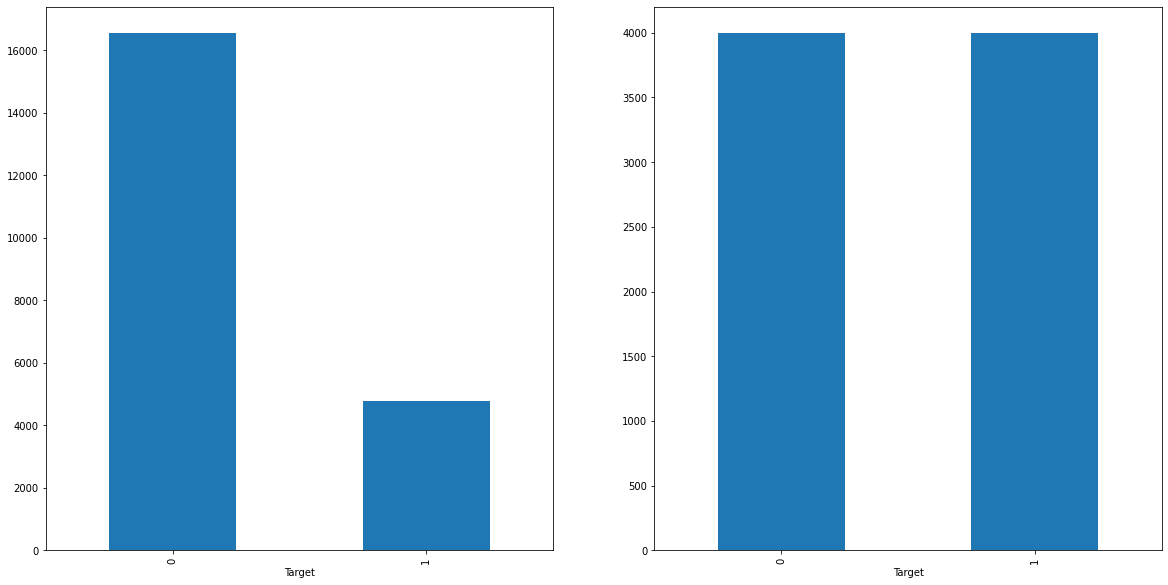

In [ ]:
TRAIN_SAMPLES=12000
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
df_train.groupby('Target').size().plot.bar(ax=ax1)
train_df = df_train.groupby('Target')
train_df = train_df.apply(lambda x: x.sample(TRAIN_SAMPLES//3))
train_df = train_df.reset_index(drop=True)
train_df.groupby('Target').size().plot.bar(ax=ax2) 
print(train_df.shape[0], 'new training size')

In [ ]:
train_df.shape

(8000, 3)

In [ ]:
print('Training, Validation and Test set is ~equally distributed on target'); print('--'*40)
print('Distribution of target in the training set:'); 
display(pd.Series(train_df['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the validation set:'); 
display(pd.Series(df_valid['Target']).value_counts(normalize = True).round(2))
print('\nDistribution of target in the test set:'); 
display(pd.Series(df_test['Target']).value_counts(normalize = True).round(2))

Training, Validation and Test set is ~equally distributed on target
--------------------------------------------------------------------------------
Distribution of target in the training set:


0    0.5
1    0.5
Name: Target, dtype: float64


Distribution of target in the validation set:


0    0.78
1    0.22
Name: Target, dtype: float64


Distribution of target in the test set:


0    0.77
1    0.23
Name: Target, dtype: float64

In [ ]:
print('Save the train, valid and test dataframes for future use');print('--'*40)
df_train.to_pickle(OUTPUT_DIR + 'train_data.pkl')
df_valid.to_pickle(OUTPUT_DIR + 'valid_data.pkl')
df_test.to_pickle(OUTPUT_DIR + 'test_data.pkl')

Save the train, valid and test dataframes for future use
--------------------------------------------------------------------------------


## Model - DenseNet121

In [ ]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_densenet.h5'
FINAL_MODEL = 'best_densenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

In [ ]:
# Model Parameters
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCH = 10
LEARNING_RATE = 1e-4
MONITOR = 'val_loss'
MODE = 'min'
VERBOSE = 1
FACTOR = 0.1
PATIENCE = 5
COOLDOWN = 5
BEST_MODEL = 'best_mobilenet.h5'
FINAL_MODEL = 'best_mobilenet_final.h5'
LOG_FILE = 'logs.csv'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

In [ ]:
train_df['Target'] = train_df['Target'].astype(str); 
df_valid['Target'] = df_valid['Target'].astype(str); 
df_test['Target'] = df_test['Target'].astype(str)

In [ ]:
img_gen_args = dict(samplewise_center=False, 
                                      samplewise_std_normalization=False, 
                                      horizontal_flip = True, 
                                      vertical_flip = False, 
                                      height_shift_range = 0.05, 
                                      width_shift_range = 0.02, 
                                      rotation_range = 3, 
                                      shear_range = 0.01,
                                      fill_mode = 'nearest',
                                      zoom_range = 0.05,
                                       preprocessing_function=preprocess_input)
img_gen = ImageDataGenerator(**img_gen_args)


In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, seed = None, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways: seed: {}'.format(seed))
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                              seed = seed,
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values,0)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen.filepaths.extend(df_gen.filenames)
    df_gen._set_index_array()
    #df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
try:
    with tf.device('/device:GPU:0'):
        train_generator = flow_from_dataframe(img_gen, train_df, 
                                    path_col = 'path',
                                   y_col = 'Target', 
                                  target_size = IMAGE_SIZE,
                                 color_mode = 'rgb',
                                batch_size = BATCH_SIZE)

        validation_generator = flow_from_dataframe(img_gen, df_valid, 
                                     path_col = 'path',
                                    y_col = 'Target', 
                                    target_size = IMAGE_SIZE,
                                     color_mode = 'rgb',
                                    batch_size = 256) # we can use much larger batches for evaluation

except RuntimeError as e:
    print(e)

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 8000 images
## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2668 images


In [ ]:
test_generator = flow_from_dataframe(img_gen, df_test, 
                                     path_col = 'path',
                                    y_col = 'Target', 
                                    target_size = IMAGE_SIZE,
                                     color_mode = 'rgb',
                                    batch_size = 32)

## Ignore next message from keras, values are replaced anyways: seed: None
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2668 images


(32, 224, 224, 3) (32,)


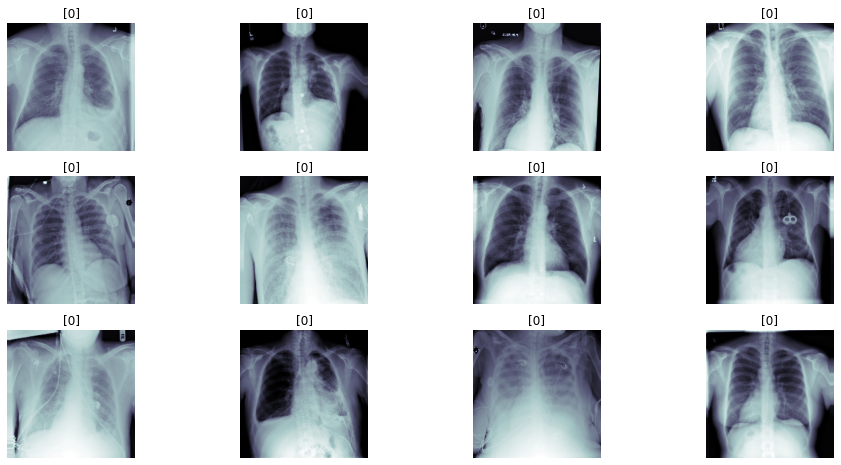

In [ ]:
t_x, t_y = next(train_generator)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(3, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    c_ax.set_title('%s'% [np.argmax(c_y)])
    c_ax.axis('off')

In [ ]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, AvgPool2D
from keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam
from keras import layers
from keras.applications.densenet import DenseNet201, DenseNet121
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau,CSVLogger


In [ ]:
#Densenet
def build_model():
    print('Create a `DenseNet121` model'); print('--'*40)
    input_shape = (224,224, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = DenseNet121(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'DenseNet121')
    
    model = Sequential(name = 'DenseNet121')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    callbacks_list = [cp, csv_logger, lrscheduler]
    return callbacks_list

In [ ]:
print('Lets fit the model.....')
#K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks_list = callbacks()
    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = train_generator.n//BATCH_SIZE,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks_list,
                                  validation_data = validation_generator)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `DenseNet121` model
--------------------------------------------------------------------------------
29097984/29084464 [==============================] - 1s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DenseNet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 7,038,529
Trainable params: 6,954,881
No

In [ ]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [ ]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy = model.evaluate_generator(generator = validation_generator)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.342, Accuracy: 0.852


In [ ]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
11/11 [==============================] - 56s 5s/step


In [ ]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                              verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 66s 782ms/step


In [ ]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.487


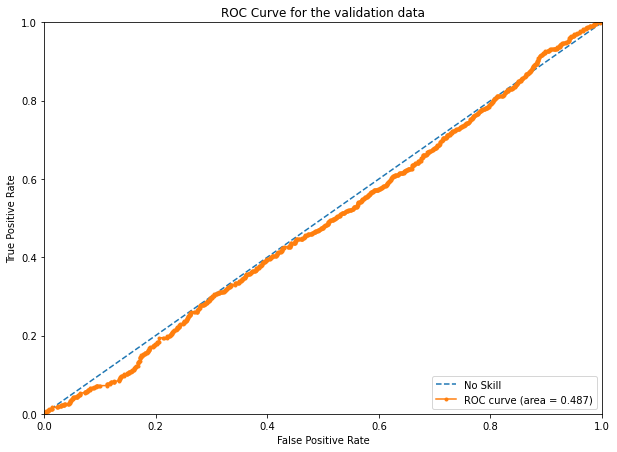

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.491


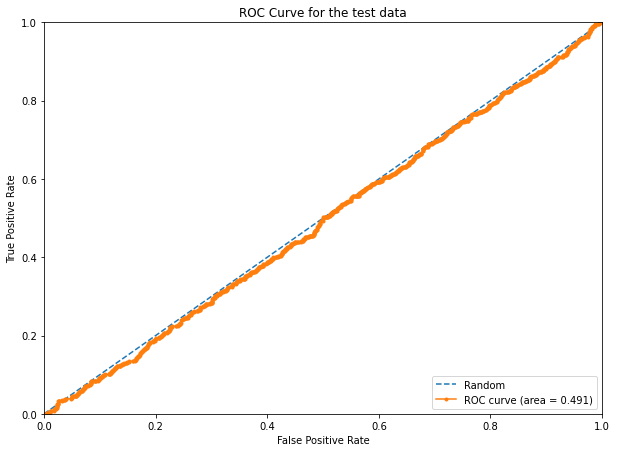

In [ ]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


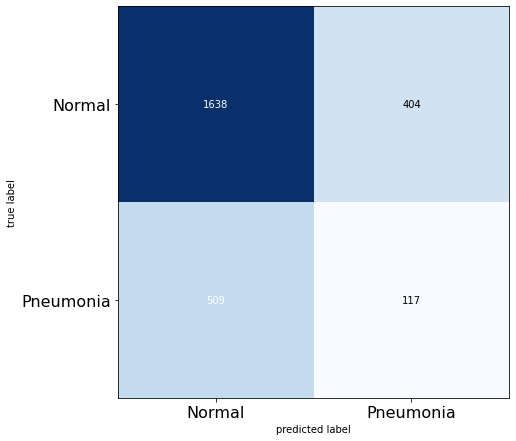

In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.76      0.80      0.78      2042
   Pneumonia       0.22      0.19      0.20       626

    accuracy                           0.66      2668
   macro avg       0.49      0.49      0.49      2668
weighted avg       0.64      0.66      0.65      2668



## **MObileNet With Image** **Augmentation**

In [ ]:
#Mobile net
def build_model():
    print('Create a `MobileNet` model'); print('--'*40)
    input_shape = (224,224, 3)
    inputs = Input(shape = input_shape)
    initializer = tf.keras.initializers.GlorotNormal()
    
    base_model = MobileNet(include_top = False, input_tensor = inputs, weights ='imagenet')
    
    densenet = Model(inputs = inputs, outputs = base_model.layers[-1].output, name = 'MobileNet')
    
    model = Sequential(name = 'MobileNet')
    model.add(densenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = initializer))
    model.summary()
    return model

def callbacks():
    
    model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = LOSS, metrics = METRICS)
    
    cp = ModelCheckpoint(filepath = MODEL_WEIGHTS + BEST_MODEL, monitor = MONITOR, 
                         verbose = VERBOSE, save_best_only = True, mode = MODE)
    
    if os.path.exists(MODEL_WEIGHTS + LOG_FILE): os.remove(MODEL_WEIGHTS + LOG_FILE)
    csv_logger = CSVLogger(MODEL_WEIGHTS + LOG_FILE, append = True)
    lrscheduler = ReduceLROnPlateau(monitor = MONITOR, factor = FACTOR, 
                                    patience = PATIENCE, verbose = VERBOSE, 
                                    mode = MODE, cooldown = COOLDOWN)
    
    callbacks_list = [cp, csv_logger, lrscheduler]
    return callbacks_list

In [ ]:
print('Lets fit the model.....')
#K.clear_session()
with strategy.scope():
    model = build_model()
    callbacks_list = callbacks()
    
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch = train_generator.n//BATCH_SIZE,
                                  epochs = EPOCH, verbose = VERBOSE, 
                                  callbacks = callbacks_list,
                                  validation_data = validation_generator)
    print('Save the final weights'); print('--'*40)
    model.save(MODEL_WEIGHTS + FINAL_MODEL)

Lets fit the model.....
Create a `MobileNet` model
--------------------------------------------------------------------------------
Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobileNet (Functional)      (None, 7, 7, 1024)        3228864   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
__________________________________________

In [ ]:
print('Reloading model weights and lets evaluate on validation set'); print('--'*40)
model.load_weights(MODEL_WEIGHTS + BEST_MODEL)

Reloading model weights and lets evaluate on validation set
--------------------------------------------------------------------------------


In [ ]:
print('Evaluate the model on validation data'); print('--'*40)

loss, accuracy = model.evaluate_generator(generator = validation_generator)
print(f'Loss: {round(loss, 3)}, Accuracy: {round(float(accuracy), 3)}')

Evaluate the model on validation data
--------------------------------------------------------------------------------
Loss: 0.411, Accuracy: 0.822


In [ ]:
print('Predict on the validation data'); print('--'*40)
validation_generator.reset()
valid_pred_roc = model.predict_generator(generator = validation_generator,
                                         verbose = 1)
valid_pred = []
for i in valid_pred_roc:
    if i >= 0.5: valid_pred.append(1)
    else: valid_pred.append(0)
y_valid = df_valid['Target'].astype(int).values

Predict on the validation data
--------------------------------------------------------------------------------
11/11 [==============================] - 56s 5s/step


In [ ]:
print('Predict on the test data'); print('--'*40)
test_generator.reset()
test_pred_roc = model.predict_generator(generator = test_generator,
                              verbose = 1)
test_pred = []
for i in test_pred_roc:
    if i >= 0.5: test_pred.append(1)
    else: test_pred.append(0)
y_test = df_test['Target'].astype(int).values

Predict on the test data
--------------------------------------------------------------------------------
84/84 [==============================] - 841s 10s/step


In [ ]:
display(pd.Series(y_valid).value_counts(), pd.Series(y_test).value_counts())

0    2071
1     597
dtype: int64

0    2042
1     626
dtype: int64

ROC Curve for the validation data
--------------------------------------------------------------------------------
AUC: 0.503


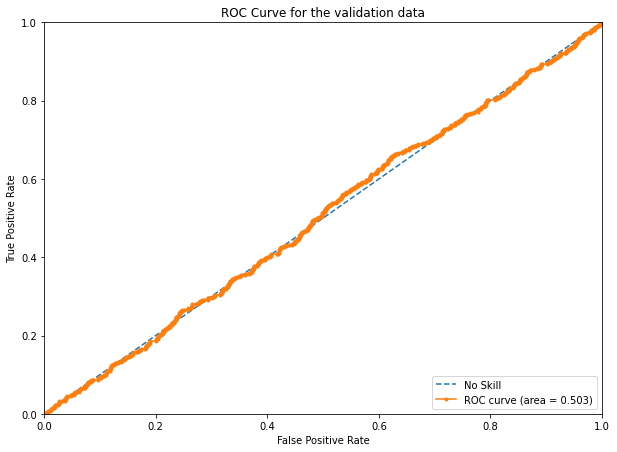

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
print('ROC Curve for the validation data'); print('--'*40)

roc_auc_valid = roc_auc_score(y_valid, np.array(valid_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_valid))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_valid, np.array(valid_pred_roc).reshape(-1))
plt.title('ROC Curve for the validation data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'No Skill')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_valid)
plt.legend(loc = 'lower right')
plt.show()

ROC Curve for the test data
--------------------------------------------------------------------------------
AUC: 0.490


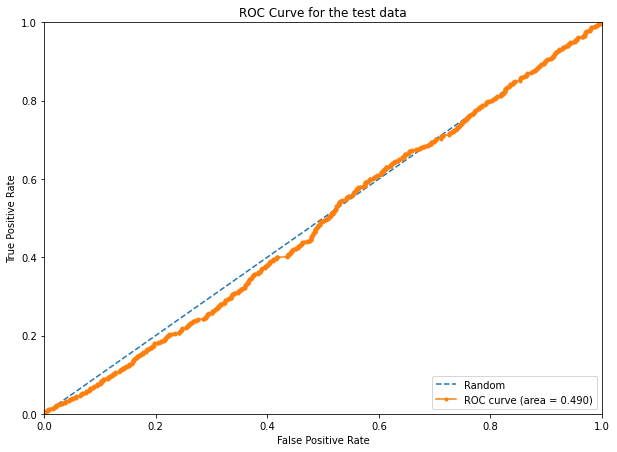

In [ ]:
print('ROC Curve for the test data'); print('--'*40)

roc_auc_test = roc_auc_score(y_test, np.array(test_pred_roc).reshape(-1))
print('AUC: {:0.3f}'.format(roc_auc_test))

fig = plt.figure(figsize = (10, 7.2))
fpr, tpr, thresholds = roc_curve(y_test, np.array(test_pred_roc).reshape(-1))
plt.title('ROC Curve for the test data')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.axis([0, 1, 0, 1])
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Random')
plt.plot(fpr, tpr, marker = '.', label = 'ROC curve (area = %0.3f)' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.show()

Confusion Matrix on the test data
--------------------------------------------------------------------------------


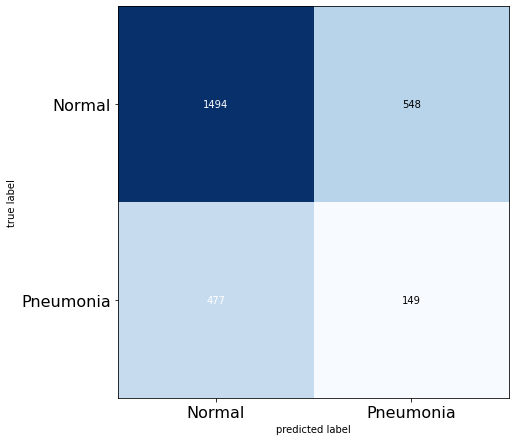

In [ ]:
from sklearn.metrics import confusion_matrix
print('Confusion Matrix on the test data'); print('--'*40)
cm = confusion_matrix(y_test, test_pred)
plot_confusion_matrix(cm, figsize = (10, 7.2), cmap = plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize = 16)
plt.show()

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, roc_auc_score,classification_report
from sklearn.metrics import classification_report

print('Classification Report on the test data'); print('--'*60)
print(classification_report(y_test, test_pred, target_names = ['Normal', 'Pneumonia']))

Classification Report on the test data
------------------------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.76      0.73      0.74      2042
   Pneumonia       0.21      0.24      0.23       626

    accuracy                           0.62      2668
   macro avg       0.49      0.48      0.48      2668
weighted avg       0.63      0.62      0.62      2668



# Unet with Mobile **net**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [ ]:
# Imports
import os
import cv2
import glob
import time
import pydicom
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [ ]:
#load merged_df.pkl. This contains all merged data from both CSV files for training.
merged_df = pd.read_pickle('/content/drive/MyDrive/Colab/capstoneCV1/pklfiles/merged_df.pkl')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   patientId           30227 non-null  object  
 1   x                   9555 non-null   float64 
 2   y                   9555 non-null   float64 
 3   width               9555 non-null   float64 
 4   height              9555 non-null   float64 
 5   Target              30227 non-null  int64   
 6   class               30227 non-null  object  
 7   y_max               9555 non-null   float64 
 8   x_max               9555 non-null   float64 
 9   Modality            30227 non-null  object  
 10  ConversionType      30227 non-null  object  
 11  PatientSex          30227 non-null  object  
 12  PatientAge          30227 non-null  int64   
 13  Body Part Examined  30227 non-null  object  
 14  ViewPosition        30227 non-null  object  
 15  Rows                30227 non-null  

In [ ]:
cd "/content/drive/MyDrive/Colab/capstoneCV1/data"

/content/drive/MyDrive/Colab/capstoneCV1/data


In [ ]:
# Reference image directories
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

labelsPath = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"
# Creating an array of the test & training file paths
#trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
#testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

In [ ]:
new_df=merged_df

In [ ]:
#fill na with 0 for x,y,x_max,y_max
new_df['x']=new_df['x'].fillna(0)
new_df['y']=new_df['y'].fillna(0)
new_df['x_max']=new_df['x_max'].fillna(0)
new_df['y_max']=new_df['y_max'].fillna(0)
new_df['width']=new_df['width'].fillna(0)
new_df['height']=new_df['height'].fillna(0)

In [ ]:
train_Data = merged_df[0:6000]
val_Data = merged_df[8000:10000]

In [ ]:
new_df['Columns'].isna().sum()

0

Check distribution of target variable in train and val data.

In [ ]:
train_Data.Target.value_counts()

0    3459
1    2541
Name: Target, dtype: int64

In [ ]:
val_Data.Target.value_counts()

0    1665
1     335
Name: Target, dtype: int64

In [ ]:
import math

In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input 
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence


BATCH_SIZE = 10

## Image Size to be scaled
IMAGE_SIZE = 224


## Actual Image size 
IMG_WIDTH = 1024
IMG_HEIGHT = 1024


class TrainGenerator(Sequence):

    def __init__(self,  _labels):       
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __doHistogramEqualization(self,img):
        # Pre processing Histogram equalization
        histogram_array = np.bincount(img.flatten(), minlength=256)
        #normalize
        num_pixels = np.sum(histogram_array)
        histogram_array = histogram_array/num_pixels
        #normalized cumulative histogram
        chistogram_array = np.cumsum(histogram_array)
        """
        STEP 2: Pixel mapping lookup table
        """
        transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
        """
        STEP 3: Transformation
        """
        img_list = list(img.flatten())

        # transform pixel values to equalize
        eq_img_list = [transform_map[p] for p in img_list]

        # reshape and write back into img_array
        img = np.reshape(np.asarray(eq_img_list), img.shape)

        return img

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = '/content/drive/MyDrive/Colab/capstoneCV1/data/stage_2_train_images/'+'{}.dcm'.format(_pid)
            _imgData = pydicom.read_file(_path)

            img = _imgData.pixel_array 


            # Resize image
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            
            resized_img = self.__doHistogramEqualization(resized_img)
        
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks


In [ ]:
#addign train and validation data generator
trainUNetDataGen = TrainGenerator( train_Data)
validateUNetDataGen = TrainGenerator( val_Data)

In [ ]:
def showMaskedImage(_imageSet, _maskSet, _index) :
    maskImage = _imageSet[_index]
    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    plt.imshow(maskImage[:,:,0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


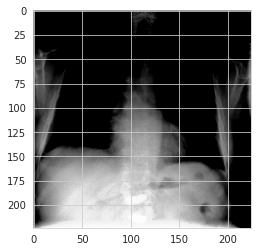

In [ ]:
imageSet0 = trainUNetDataGen[1][0][1]
plt.imshow(imageSet0)

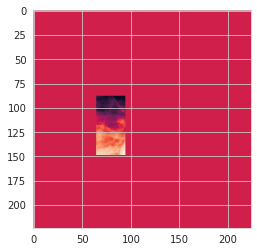

In [ ]:
## Masks for the same
imageSet0 = trainUNetDataGen[2][0]
maskSet0 = trainUNetDataGen[2][1]    
showMaskedImage(imageSet0, maskSet0, 5)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D

In [ ]:
LR = 1e-4
ALPHA = 1.0
def create_UNetModelUsingMobileNet(trainable=True):
    """Function to create UNet architecture with MobileNet.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
    # concatinate with the original image layer of the same size from MobileNet
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)


In [ ]:
## Build a model 
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = create_UNetModelUsingMobileNet(input_shape)
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

In [ ]:
#dice_coef 2 * the Area of Overlap divided by the total number of pixels in both images
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

## Loss is 1 - the coefficent of two images
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [ ]:
## Call Backs for ealy stopping and reduce learning rate 
## Reduce the learning rate when teh validation loss is same for 4 epocs
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [ ]:
## Optimiser , metrics and loss for the model
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [ ]:
## Running the model
train_steps = len(trainUNetDataGen)//BATCH_SIZE
valid_steps = len(validateUNetDataGen)//BATCH_SIZE

if len(trainUNetDataGen) % BATCH_SIZE != 0:
    train_steps += 1
if len(validateUNetDataGen) % BATCH_SIZE != 0:
    valid_steps += 1


history = model.fit(trainUNetDataGen,
                        epochs=20,
                        steps_per_epoch=train_steps,
                        validation_data=validateUNetDataGen,
                        callbacks=callbacks,
                        use_multiprocessing=True,
                        workers=4,
                        validation_steps=valid_steps,                      
                        shuffle=True)


Epoch 1/20
60/60 [==============================] - 435s 7s/step - loss: 0.7312 - dice_coef: 0.2688 - recall: 0.4940 - precision: 0.2289 - val_loss: 0.9167 - val_dice_coef: 0.0833 - val_recall: 0.1964 - val_precision: 0.0979 - lr: 1.0000e-04
Epoch 2/20
60/60 [==============================] - 445s 7s/step - loss: 0.6731 - dice_coef: 0.3269 - recall: 0.5160 - precision: 0.2968 - val_loss: 0.8822 - val_dice_coef: 0.1178 - val_recall: 0.4955 - val_precision: 0.1107 - lr: 1.0000e-04
Epoch 3/20
60/60 [==============================] - 429s 7s/step - loss: 0.6842 - dice_coef: 0.3158 - recall: 0.4885 - precision: 0.2750 - val_loss: 0.8813 - val_dice_coef: 0.1187 - val_recall: 0.4943 - val_precision: 0.0957 - lr: 1.0000e-04
Epoch 4/20
60/60 [==============================] - 447s 7s/step - loss: 0.6630 - dice_coef: 0.3370 - recall: 0.5028 - precision: 0.3062 - val_loss: 0.8851 - val_dice_coef: 0.1149 - val_recall: 0.5795 - val_precision: 0.0939 - lr: 1.0000e-04
Epoch 5/20
60/60 [==============

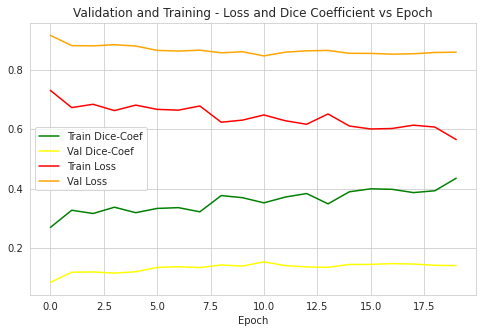

In [ ]:
## PLot Matrix between training and validation data
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.plot(history.history['dice_coef'],     label='Train Dice-Coef',      color = "green" );
plt.plot(history.history['val_dice_coef'], label='Val Dice-Coef',  color = "yellow");
plt.plot(history.history['loss'],         label='Train Loss',          color = "red"   );
plt.plot(history.history['val_loss'],     label='Val Loss',      color = "orange");
plt.title("Validation and Training - Loss and Dice Coefficient vs Epoch")
plt.xlabel("Epoch")
plt.legend();

The performance can further be improved using the original resolution and hyperparameter tuning.

In [ ]:
##Preparing test data , picked up random 5 images
test_Data = merged_df[12000:12020]
test_Data.Target.value_counts()

0    15
1     5
Name: Target, dtype: int64

In [ ]:
## Setting the custom generator for test data
testUNetDataGen = TrainGenerator(test_Data)

In [ ]:
## evaluating the model
test_steps = (len(testUNetDataGen)//BATCH_SIZE)
if len(testUNetDataGen) % BATCH_SIZE != 0:
    test_steps += 1

model.evaluate(testUNetDataGen)

2/2 [==============================] - 5s 2s/step - loss: 0.6935 - dice_coef: 0.3065 - recall: 0.8129 - precision: 0.1784


[0.6934551000595093,
 0.3065448999404907,
 0.8128776550292969,
 0.1783839762210846]

In [ ]:
pred_mask = model.predict(testUNetDataGen)

In [ ]:
test_Data = test_Data.reset_index()

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_True = []
imageList = []
predMaskTemp = []
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
def getPredictions(test_Data):
    masks = np.zeros((int(test_Data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

    for index, row in test_Data.iterrows():
        patientId = row.patientId
        classlabel = row["Target"]
        dcm_file = '/content/drive/MyDrive/Colab/capstoneCV1/data/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = pydicom.read_file(dcm_file)
        img = dcm_data.pixel_array
        resized_img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_LINEAR)
        predMaskTemp.append(pred_mask[index])
        iou = (pred_mask[index] > 0.5) * 1.0
        y_pred.append((1 in iou) * 1)
        imageList.append(resized_img)
        y_True.append(classlabel)
        x_scale = IMAGE_HEIGHT / 1024
        y_scale = IMAGE_WIDTH / 1024

        if(classlabel == 1):
            x = int(np.round(row['x'] * x_scale))
            y = int(np.round(row['y'] * y_scale))
            w = int(np.round(row['width'] * x_scale))
            h = int(np.round(row['height'] * y_scale))
            masks[index][y:y+h, x:x+w] = 1

        
        
    tmpImages = np.array(imageList)
    tmpMask = np.array(predMaskTemp)
    originalMask = np.array(masks)
    return (y_True,y_pred,tmpImages,tmpMask ,originalMask)
    
def print_confusion_matrix(y_true, y_pred):
    '''Function to print confusion_matrix'''

    # Get confusion matrix array
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))

    print("Total samples = ", len(test_Data))

    # Plot heatmap and get sns heatmap values
    sns.set(font_scale=1.4); # for label size
    result = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False); 

    # Add labels to heatmap
    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
    
    plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return


In [ ]:
y_true,y_pred ,imagelist , maskList , originalMask = getPredictions(test_Data)

Text(0.5, 0, 'Pneumonia 0:')

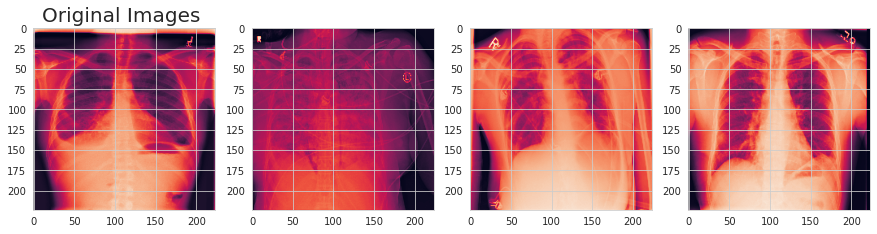

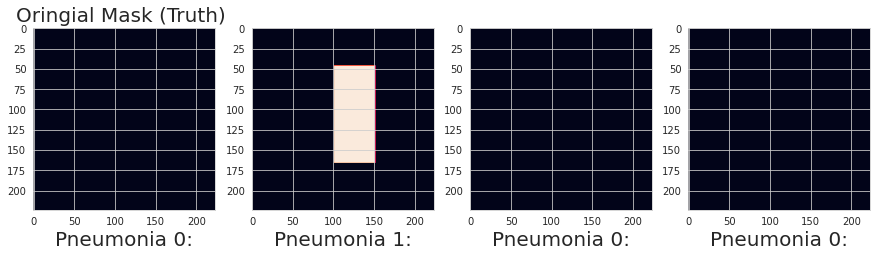

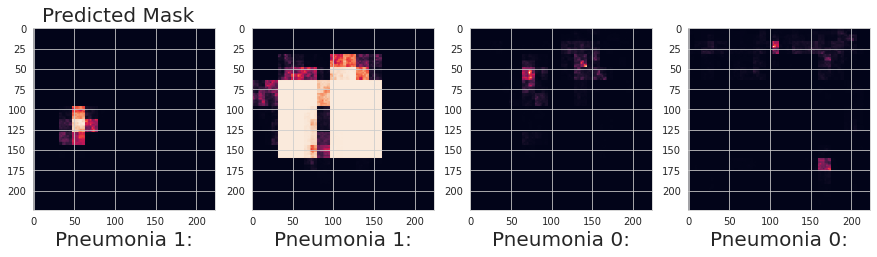

In [ ]:
## Visualising the train and output data 
##
fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(imagelist[1])
a.set_title('Original Images ',fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(imagelist[12])

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(imagelist[13])

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(imagelist[15])


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)

imgplot = plt.imshow(originalMask[1])
a.set_title('Oringial Mask (Truth) ',fontsize=20)

a.set_xlabel('Pneumonia {}:'.format(y_true[1]), fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(originalMask[12])
a.set_xlabel('Pneumonia {}:'.format(y_true[12]), fontsize=20)


a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(originalMask[13])
a.set_xlabel('Pneumonia {}:'.format(y_true[13]), fontsize=20)


a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(originalMask[15])
a.set_xlabel('Pneumonia {}:'.format(y_true[15]), fontsize=20)
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
a.set_title('Predicted Mask  ',fontsize=20)
imgplot = plt.imshow(maskList[1])
a.set_xlabel('Pneumonia {}:'.format(y_pred[1]), fontsize=20)

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(maskList[12])
a.set_xlabel('Pneumonia {}:'.format(y_pred[12]), fontsize=20)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(maskList[13])
a.set_xlabel('Pneumonia {}:'.format(y_pred[13]), fontsize=20)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(maskList[15])
a.set_xlabel('Pneumonia {}:'.format(y_pred[15]), fontsize=20)


Total samples =  20


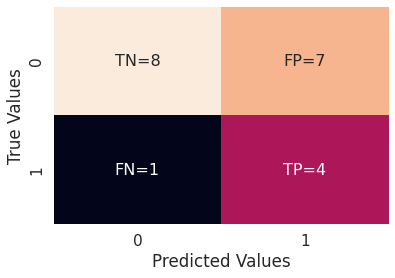

In [ ]:
print_confusion_matrix(y_true,y_pred )

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.53      0.67        15
           1       0.36      0.80      0.50         5

    accuracy                           0.60        20
   macro avg       0.63      0.67      0.58        20
weighted avg       0.76      0.60      0.63        20



# Mobilenetv2 with classification and localization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 14.6 MB/s 


In [ ]:
# Imports
import os
import cv2
import glob
import time
import pydicom
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [ ]:
#load merged_df.pkl. This contains all merged data from both CSV files for training.
merged_df = pd.read_pickle('/content/drive/MyDrive/Colab/capstoneCV1/pklfiles/merged_df.pkl')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   patientId           30227 non-null  object  
 1   x                   9555 non-null   float64 
 2   y                   9555 non-null   float64 
 3   width               9555 non-null   float64 
 4   height              9555 non-null   float64 
 5   Target              30227 non-null  int64   
 6   class               30227 non-null  object  
 7   y_max               9555 non-null   float64 
 8   x_max               9555 non-null   float64 
 9   Modality            30227 non-null  object  
 10  ConversionType      30227 non-null  object  
 11  PatientSex          30227 non-null  object  
 12  PatientAge          30227 non-null  int64   
 13  Body Part Examined  30227 non-null  object  
 14  ViewPosition        30227 non-null  object  
 15  Rows                30227 non-null  

In [ ]:
cd "/content/drive/MyDrive/Colab/capstoneCV1/data"

/content/drive/MyDrive/Colab/capstoneCV1/data


In [ ]:
# Reference image directories
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

labelsPath = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"
# Creating an array of the test & training file paths
#trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
#testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

In [ ]:
#drop duplicates
new_df=merged_df.drop_duplicates(subset='patientId',keep='first',inplace=False)

In [ ]:
new_df.shape

(26684, 19)

In [ ]:
#fill na with 0 for x,y,x_max,y_max
new_df['x']=new_df['x'].fillna(0)

In [ ]:
new_df['y']=new_df['y'].fillna(0)
new_df['x_max']=new_df['x_max'].fillna(0)
new_df['y_max']=new_df['y_max'].fillna(0)
new_df['width']=new_df['width'].fillna(0)
new_df['height']=new_df['height'].fillna(0)

In [ ]:
train_data_x=[]
train_class_y=[]
train_bbox_y=[]

In [ ]:
IMAGE_HEIGHT=1024
IMAGE_WIDTH=1024
RESIZE_HEIGHT=128
RESIZE_WIDTH=128
X_SCALE=RESIZE_HEIGHT/IMAGE_HEIGHT
Y_SCALE=RESIZE_WIDTH/IMAGE_WIDTH

In [ ]:
new_df['Columns'].isna().sum()

0

FetchImageData function reads files, resizes them to (128,128) and normalizes them. The class of the data and their bounding box are filled in respective data structures.

In [ ]:
def fetchImageData(df):
    for index, row in df.iterrows():
        pid = row['patientId']
        classlabel = row["Target"]
        file = trainImagesPath+'/'+pid+'.dcm'
        image = pydicom.read_file(file).pixel_array
        image = cv2.resize(image, (128, 128))
        image=image/255
        
        bb_x=row['x']*X_SCALE
        bb_y=row['y']*Y_SCALE
        bb_xmax=row['x_max']*X_SCALE
        bb_ymax=row['y_max']*Y_SCALE
        bb_tuple=(bb_x/255,bb_y/255,bb_xmax/255,bb_ymax/255)
        #bb_tuple=(bb_x,bb_y,bb_xmax,bb_ymax)
        #print(bb_tuple)
        train_bbox_y.append(bb_tuple)
        train_data_x.append(image)
        train_class_y.append(classlabel)
      


In [ ]:
fetchImageData(new_df[:10000])

In [ ]:
len(train_bbox_y)

27658

In [ ]:
train_X = np.array(train_data_x) # Convert to np.array
train_X_rgb = np.repeat(train_X[..., np.newaxis], 3, -1) # Reshape into rgb format

In [ ]:
len(train_X_rgb)

27658

In [ ]:
len(train_X_rgb)

27658

In [ ]:
x_train=train_X_rgb[:9000]
y_train=np.array(train_class_y[:9000])
y_bbox_train=np.array(train_bbox_y[:9000])

In [ ]:
x_val=train_X_rgb[9000:12000]
y_val=np.array(train_class_y[9000:12000])
y_bbox_val=np.array(train_bbox_y[9000:12000])

In [ ]:
np.isnan(y_bbox_train).sum()

0

In [ ]:
#read test 4 images for evaluation
testImagesPath = "stage_2_test_images"
testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

In [ ]:
len(testFilepaths)

3000

In [ ]:
"""
@Description: This decodes an image by reading the pixel array, resizing it into the correct format and
              normalising the pixels

@Inputs:
    - filePath: This is the filepath of the image that we want to decode

@Output:
    - img: This is the image after it has been decoded
"""
def decodeImage(filePath):
    image = pydicom.read_file(filePath).pixel_array
    image = cv2.resize(image, (128, 128))
    return (image/255)

In [ ]:
# Get our test x in the correct shape for NN
test_X = []

for filePath in tqdm(testFilepaths[:100]):
    img_test = decodeImage(filePath) # Decode & Resize
    test_X.append(img_test)

test_X = np.array(test_X) # Convert to np array
test_X_rgb = np.repeat(test_X[..., np.newaxis], 3, -1) # Reshape into rgb format

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


In [ ]:
len(test_X_rgb)

100

**MobileNet V2 based model.**
Sigmoid layer with 1 dense layer for classification.
1 dense layer with relu for regression and bbox detection.

In [ ]:
# These our our scoring metrics that are going to be used to evaluate our models
METRICS = ['accuracy', 
         #  tf.keras.metrics.Precision(name='precision')] 
           tf.keras.metrics.Recall(name='recall')] 
         #  tf.keras.metrics.AUC(name='AUC')]

In [ ]:
# Define our callback functions to pass when fitting our NNs
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5", save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [ ]:
#build model with classification and localization
def build_mn_cl_model():
  model = tf.keras.Sequential()
  model.add(tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3)))
  model.layers[0].trainable = False
 # print(model.layers[90].output_shape)
  #print(model.layers[90].name)
  chopped_mobilenet = Model(inputs=[model.input], outputs=[model.output]) #get_layer('Conv1')
  classification_output=tf.keras.layers.GlobalAveragePooling2D()(chopped_mobilenet.output)
  classification_output = Dense(units=1, activation='sigmoid')(classification_output)
  localization_output = Flatten()(chopped_mobilenet.output)
  localization_output = Dense(units=4, activation='relu')(localization_output)
  model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])
  model.summary()
  return model

In [ ]:
mn_cl_model=build_mn_cl_model()
mn_cl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mobilenetv2_1.00_128_input (In  [(None, 128, 128, 3  0          []                               
 putLayer)                      )]                                                                
                                                                                                  
 mobilenetv2_1.00_128 (Function  (None, 4, 4, 1280)  2257984     ['mobilenetv2_1.00_128_input[0][0
 al)                                                             ]']                              
                                                                                                  
 global_average_pooling2d (Glob  (None, 1280)        0           ['mobilenetv2_1.00_128[0][0]']   
 alAveragePooling2D)         

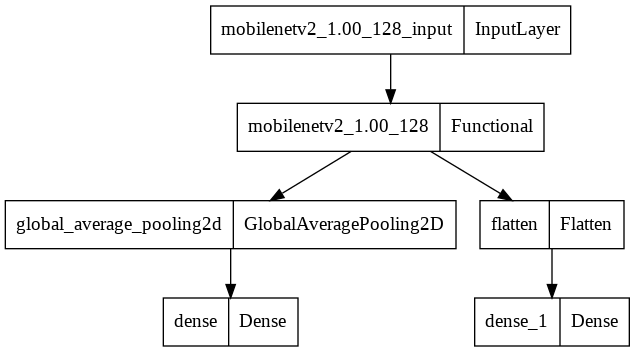

In [ ]:
tf.keras.utils.plot_model(mn_cl_model)

In [ ]:
history_mn_cl = mn_cl_model.fit(x_train, 
                          [y_train,y_bbox_train],  
                          epochs = 30, 
                          validation_data=(x_val,[y_val,y_bbox_val]),
                          #validation_split = 0.20, 
                          #class_weight = classWeight,
                          batch_size = 64)
                          
#callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler],verbose=True)

Epoch 1/30
141/141 [==============================] - 72s 511ms/step - loss: 1.8726 - dense_loss: 0.3875 - dense_1_loss: 1.4850 - dense_accuracy: 0.8251 - dense_1_accuracy: 0.7609 - val_loss: 1.0731 - val_dense_loss: 0.3617 - val_dense_1_loss: 0.7114 - val_dense_accuracy: 0.8536 - val_dense_1_accuracy: 0.8162
Epoch 2/30
141/141 [==============================] - 67s 476ms/step - loss: 1.8592 - dense_loss: 0.3741 - dense_1_loss: 1.4850 - dense_accuracy: 0.8301 - dense_1_accuracy: 0.7609 - val_loss: 1.0838 - val_dense_loss: 0.3724 - val_dense_1_loss: 0.7114 - val_dense_accuracy: 0.8457 - val_dense_1_accuracy: 0.8162
Epoch 3/30
141/141 [==============================] - 78s 556ms/step - loss: 1.8566 - dense_loss: 0.3716 - dense_1_loss: 1.4850 - dense_accuracy: 0.8318 - dense_1_accuracy: 0.7609 - val_loss: 1.0948 - val_dense_loss: 0.3834 - val_dense_1_loss: 0.7114 - val_dense_accuracy: 0.8299 - val_dense_1_accuracy: 0.8162
Epoch 4/30
141/141 [==============================] - 69s 492ms/ste

In [ ]:
def plot_training_history(history, layer):
  plt.plot(history.history[layer+'_accuracy'])
  plt.plot(history.history['val_'+layer+'_accuracy'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()
  plt.plot(history.history[layer+'_loss'])
  plt.plot(history.history['val_'+layer+'_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()


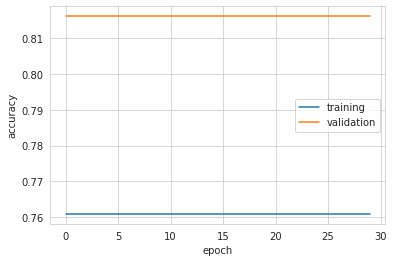

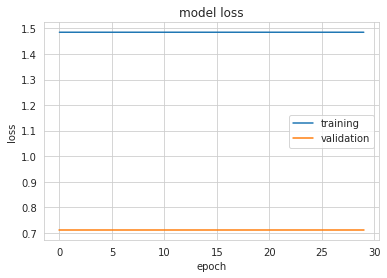

In [ ]:
#the graph for Bounding box is plotted below.
plot_training_history(history_mn_cl,'dense_1')

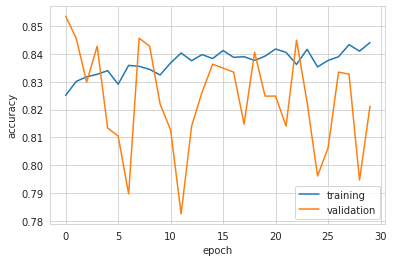

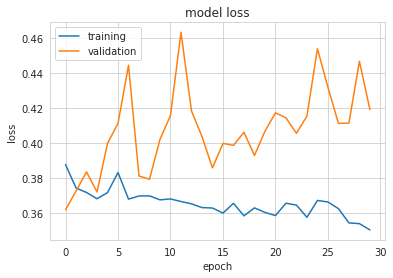

In [ ]:
#the graph for classification is plotted below.
plot_training_history(history_mn_cl,'dense')

The graph for classification accuracy indicates that it remains steady for training data but varies significantly for validation data.  The accuracy for validation data oscillates a lot. The loss also oscilates a lot for validation while remaining more or less linear for training data. This also implies model has stopped learning after somepoint.

In case of bounding box detection , validation accuracy is better than training accuracy. The training loss is more than validation loss.
This could be due to class imbalance in the data.

In [ ]:
def plot_with_box(image_data, bounding_box):
  fig,ax = plt.subplots(1)
  ax.imshow(image_data)
  # Creating a Rectangle patch for the changed one
  boxA = patches.Rectangle((bounding_box.xmin, bounding_box.ymin),
  bounding_box.xmax - bounding_box.xmin,
  bounding_box.ymax - bounding_box.ymin,
  linewidth=3, edgecolor='y', facecolor='none')
  # Add the patch to the Axes
  ax.add_patch(boxA)
  plt.show()


In [ ]:
test_X_rgb[0].shape
img=np.array(test_X_rgb[0])
img.shape

(128, 128, 3)

In [ ]:
#evaluate model on test data for 10 samples
bbox=(0,0,0,0)
pred,bbox = mn_cl_model.predict(test_X_rgb[40:41])
bbox

array([[0., 0., 0., 0.]], dtype=float32)

**Mobilenet V2 using output of layer 90 for classification and localization**

In [ ]:
#build model with classification and localization
def build_mn_cl_loc_model():
  model=tf.keras.applications.MobileNetV2(include_top = False, weights="imagenet", input_shape=(128, 128, 3))
  model.layers[0].trainable = False
  chopped_mobilenet = Model(inputs=[model.input], outputs=[model.layers[90].output]) #get_layer('Conv1')
  classification_output=tf.keras.layers.GlobalAveragePooling2D()(chopped_mobilenet.output)
  classification_output = Dense(units=1, activation='sigmoid')(classification_output)
  localization_output = Flatten()(chopped_mobilenet.output)
  localization_output = Dense(units=4, activation='relu')(localization_output)
  model = Model(inputs=[chopped_mobilenet.input], outputs=[classification_output, localization_output])
  model.summary()
  return model

In [ ]:
mn_cl_loc_model=build_mn_cl_loc_model()
mn_cl_loc_model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

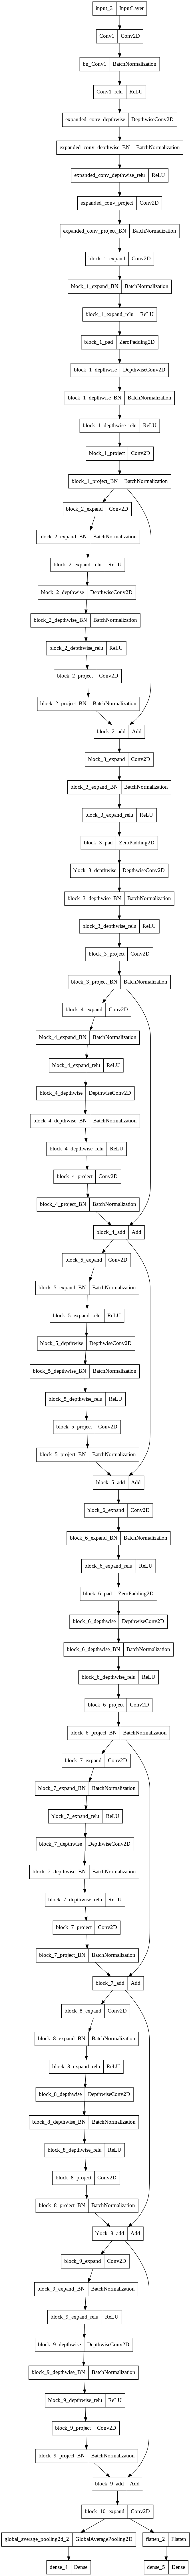

In [ ]:
tf.keras.utils.plot_model(mn_cl_loc_model)

In [ ]:
history_mn_cl_loc = mn_cl_loc_model.fit(x_train, 
                          [y_train,y_bbox_train],  
                          epochs = 30, 
                          validation_data=(x_val,[y_val,y_bbox_val]),
                          #validation_split = 0.20, 
                          #class_weight = classWeight,
                          batch_size = 64)

Epoch 1/30
141/141 [==============================] - 249s 2s/step - loss: 2.0026 - dense_4_loss: 0.4794 - dense_5_loss: 1.5232 - dense_4_accuracy: 0.7744 - dense_5_accuracy: 0.7581 - val_loss: 1.6807 - val_dense_4_loss: 0.9693 - val_dense_5_loss: 0.7114 - val_dense_4_accuracy: 0.3123 - val_dense_5_accuracy: 0.8162
Epoch 2/30
141/141 [==============================] - 243s 2s/step - loss: 1.8804 - dense_4_loss: 0.3954 - dense_5_loss: 1.4850 - dense_4_accuracy: 0.8182 - dense_5_accuracy: 0.7609 - val_loss: 1.1454 - val_dense_4_loss: 0.4340 - val_dense_5_loss: 0.7114 - val_dense_4_accuracy: 0.8062 - val_dense_5_accuracy: 0.8162
Epoch 3/30
141/141 [==============================] - 243s 2s/step - loss: 1.8464 - dense_4_loss: 0.3613 - dense_5_loss: 1.4850 - dense_4_accuracy: 0.8374 - dense_5_accuracy: 0.7609 - val_loss: 1.1934 - val_dense_4_loss: 0.4820 - val_dense_5_loss: 0.7114 - val_dense_4_accuracy: 0.8162 - val_dense_5_accuracy: 0.8162
Epoch 4/30
141/141 [=============================

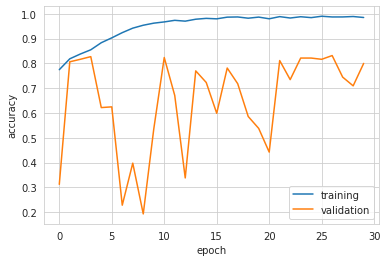

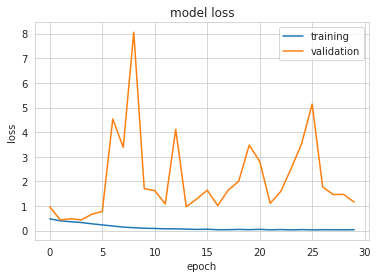

In [ ]:
#classification graphs
plot_training_history(history_mn_cl_loc,'dense_4')

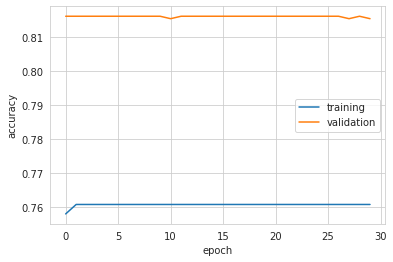

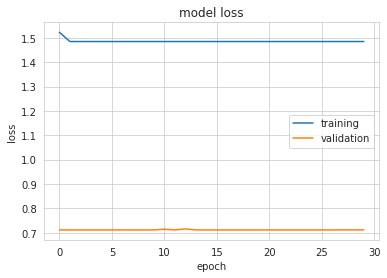

In [ ]:
#regression graphs
plot_training_history(history_mn_cl_loc,'dense_5')

In this model 90th layer output is used for classification and localization.
The bbox graphs are linear in nature. The training loss is higher and accuracy lower where as the model performed better on validation data and hence resulted in better accuracy and lower less.  It points to model underfitting?.

The classification accuracy is more for training data and loss is low. However both accuracy and loss vary a lot for validation data.